Connecting to server
Connected to server

Devices available:
R device_list 1 | CDCB11 Empatica_E4 

Connecting to device
R device_connect OK

Pausing data receiving
R pause ON

Suscribing to Temp
R device_subscribe tmp OK

Resuming data receiving
R pause OFF

Streaming...
E4_Temperature 1625250318.97927 28.79
E4_Temperature 1625250319.22929 28.79



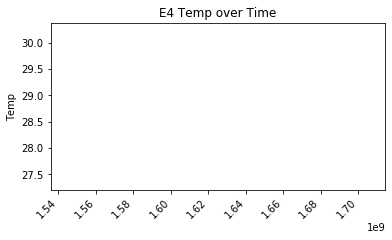

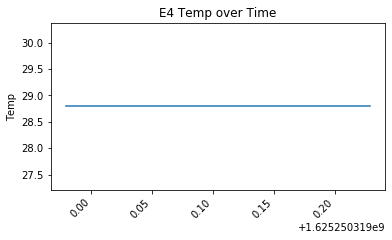

E4_Temperature 1625250319.4793 28.79
E4_Temperature 1625250319.72931 28.79
E4_Temperature 1625250319.97932 28.83
E4_Temperature 1625250320.22933 28.83
E4_Temperature 1625250320.47934 28.83
E4_Temperature 1625250320.72935 28.83



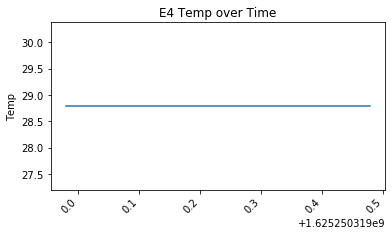

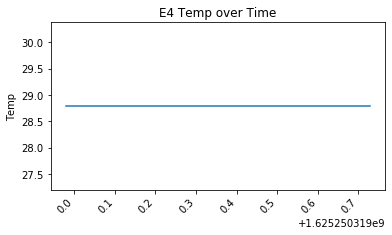

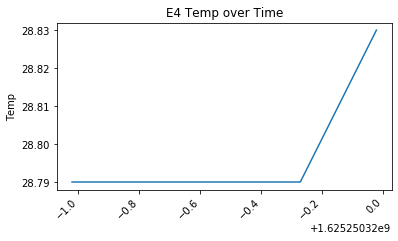

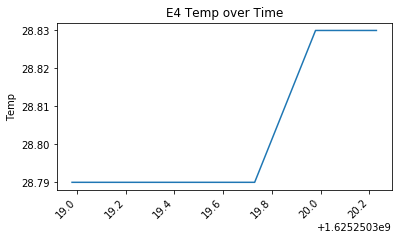

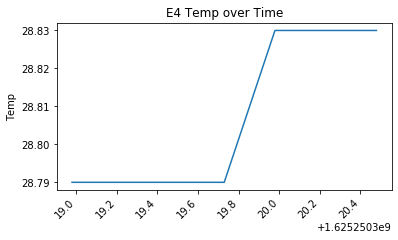

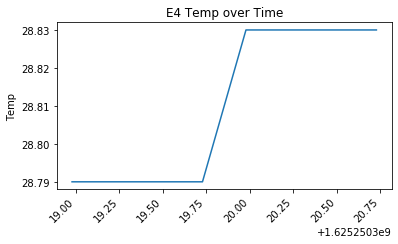

E4_Temperature 1625250320.97937 28.81



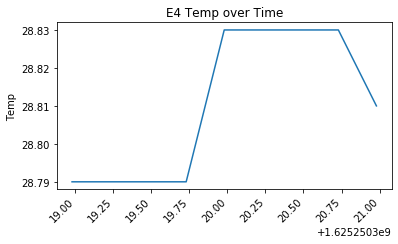

E4_Temperature 1625250321.22938 28.81
E4_Temperature 1625250321.47939 28.81
E4_Temperature 1625250321.7294 28.81
E4_Temperature 1625250321.97941 28.81
E4_Temperature 1625250322.22942 28.81
E4_Temperature 1625250322.47944 28.81
E4_Temperature 1625250322.72945 28.81



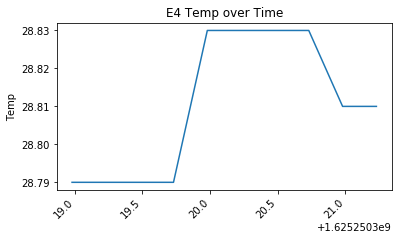

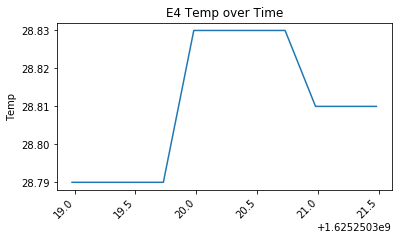

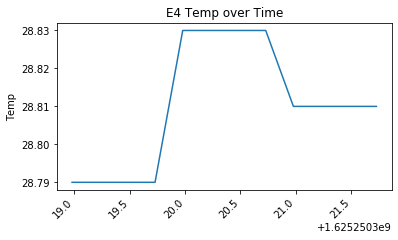

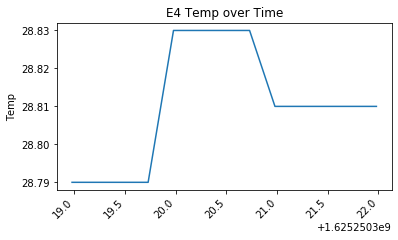

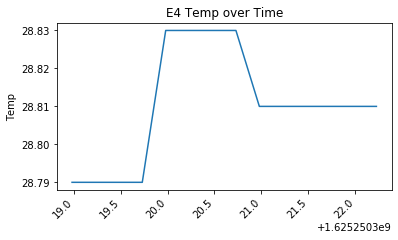

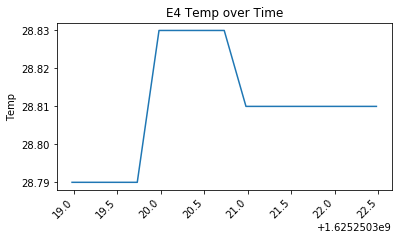

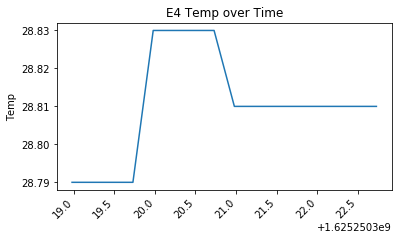

E4_Temperature 1625250322.97946 28.81



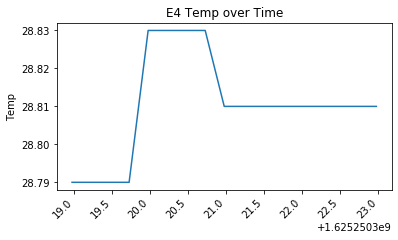

E4_Temperature 1625250323.22947 28.81
E4_Temperature 1625250323.47948 28.81
E4_Temperature 1625250323.72949 28.81
E4_Temperature 1625250323.97951 28.83
E4_Temperature 1625250324.22952 28.83
E4_Temperature 1625250324.47953 28.83
E4_Temperature 1625250324.72954 28.83



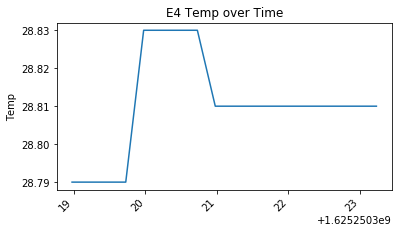

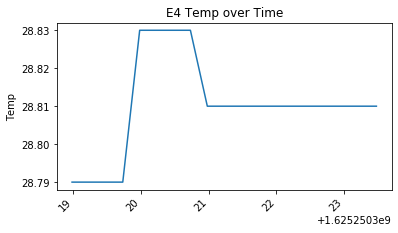

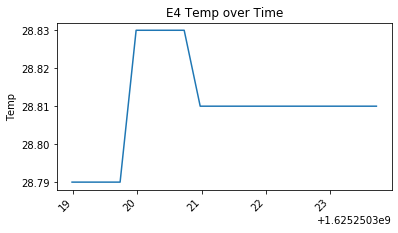

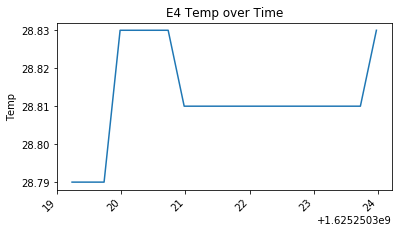

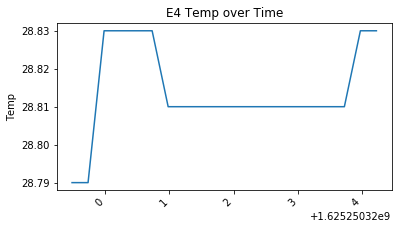

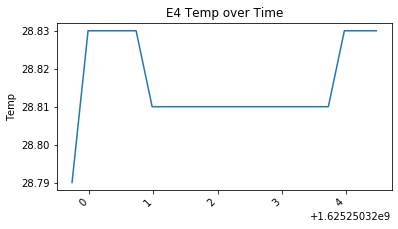

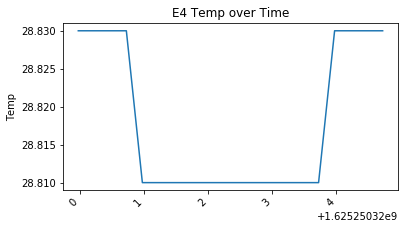

E4_Temperature 1625250324.97955 28.81



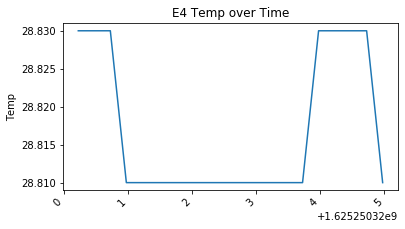

E4_Temperature 1625250325.22956 28.81
E4_Temperature 1625250325.47957 28.81
E4_Temperature 1625250325.72959 28.81
E4_Temperature 1625250325.9796 28.83
E4_Temperature 1625250326.22961 28.83
E4_Temperature 1625250326.47962 28.83
E4_Temperature 1625250326.72963 28.83



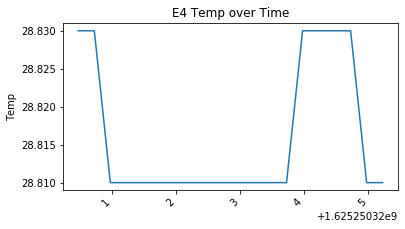

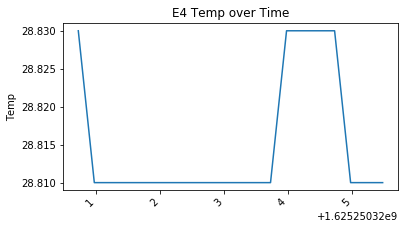

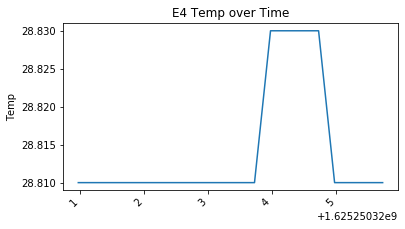

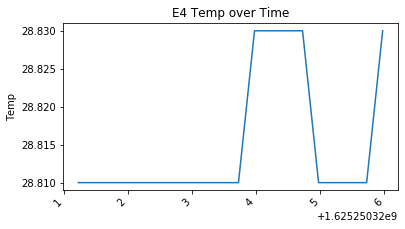

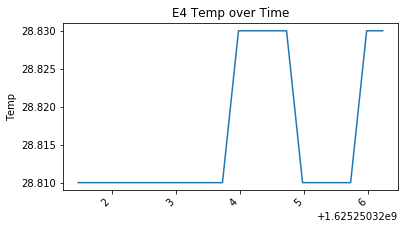

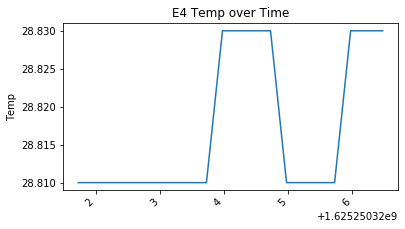

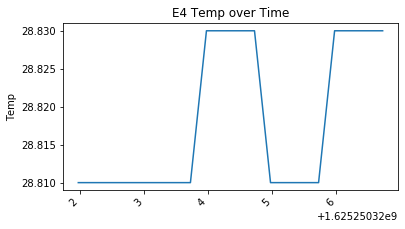

E4_Temperature 1625250326.97964 28.81
E4_Temperature 1625250327.22966 28.81
E4_Temperature 1625250327.47967 28.81
E4_Temperature 1625250327.72968 28.81
E4_Temperature 1625250327.97969 28.85
E4_Temperature 1625250328.2297 28.85
E4_Temperature 1625250328.47971 28.85
E4_Temperature 1625250328.72973 28.85



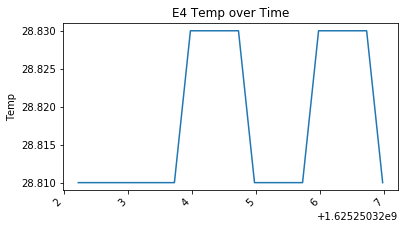

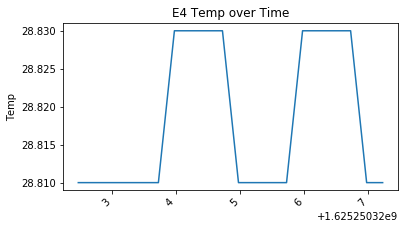

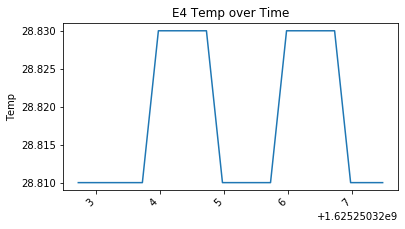

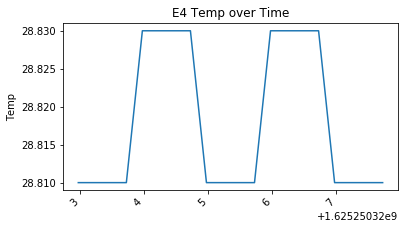

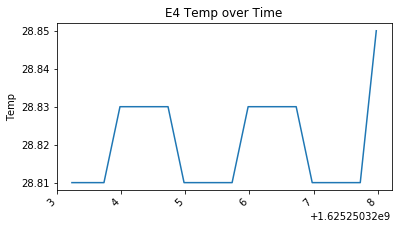

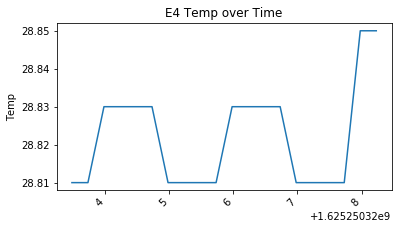

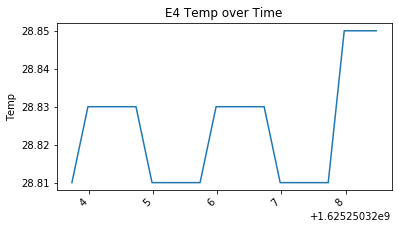

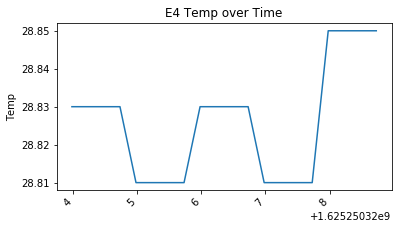

E4_Temperature 1625250328.97974 28.85
E4_Temperature 1625250329.22975 28.85



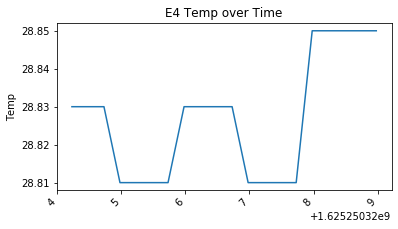

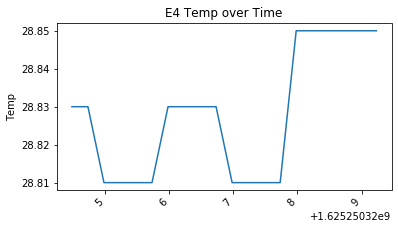

E4_Temperature 1625250329.47976 28.85
E4_Temperature 1625250329.72977 28.85
E4_Temperature 1625250329.97978 28.83
E4_Temperature 1625250330.22979 28.83
E4_Temperature 1625250330.47981 28.83
E4_Temperature 1625250330.72982 28.83



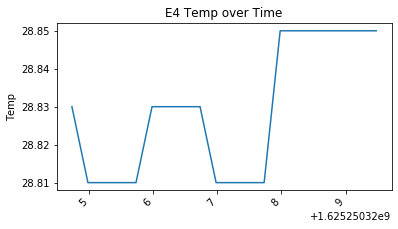

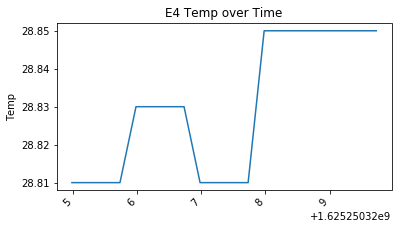

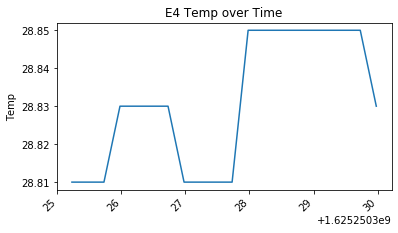

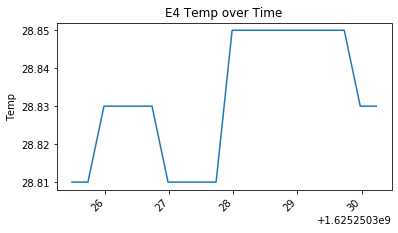

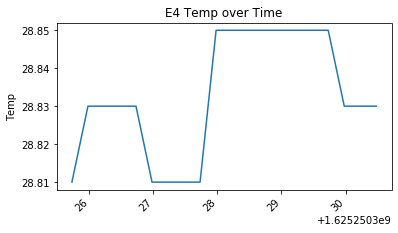

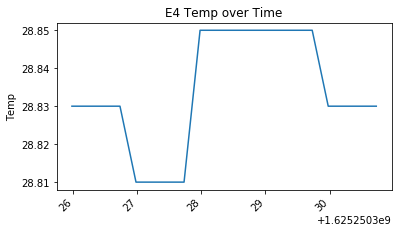

E4_Temperature 1625250330.97983 28.83



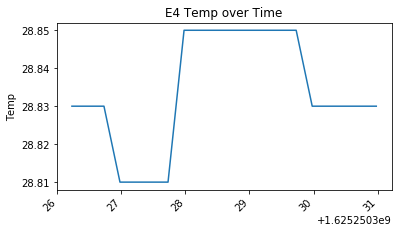

E4_Temperature 1625250331.22984 28.83
E4_Temperature 1625250331.47985 28.83
E4_Temperature 1625250331.72986 28.83
E4_Temperature 1625250331.97988 28.85
E4_Temperature 1625250332.22989 28.85
E4_Temperature 1625250332.4799 28.85
E4_Temperature 1625250332.72991 28.85



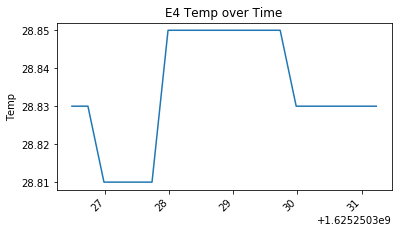

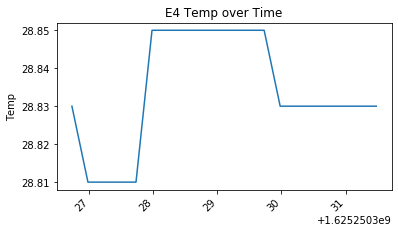

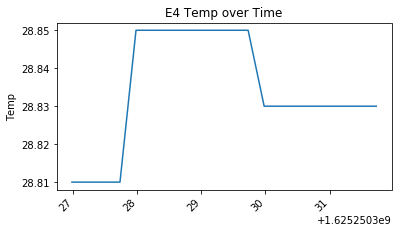

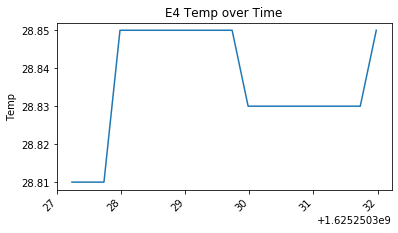

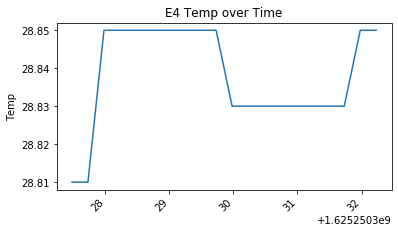

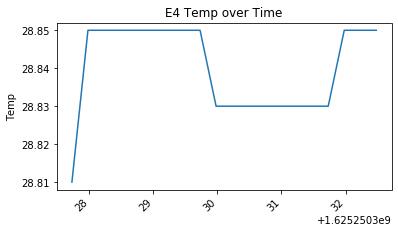

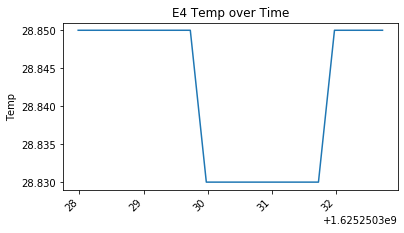

E4_Temperature 1625250332.97992 28.85



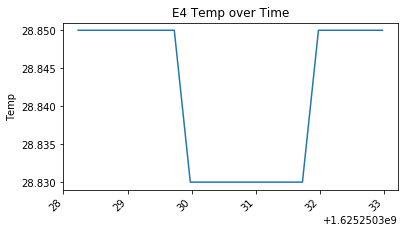

E4_Temperature 1625250333.22993 28.85
E4_Temperature 1625250333.47995 28.85
E4_Temperature 1625250333.72996 28.85
E4_Temperature 1625250333.97997 28.85
E4_Temperature 1625250334.22998 28.85
E4_Temperature 1625250334.47999 28.85
E4_Temperature 1625250334.73 28.85



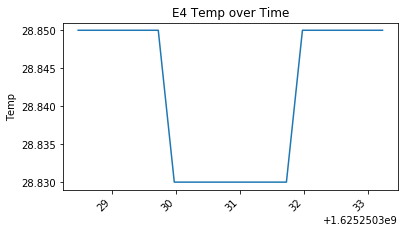

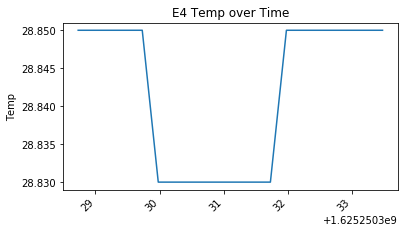

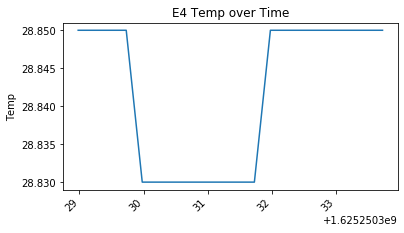

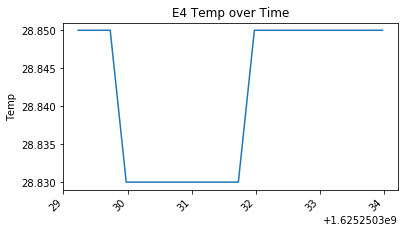

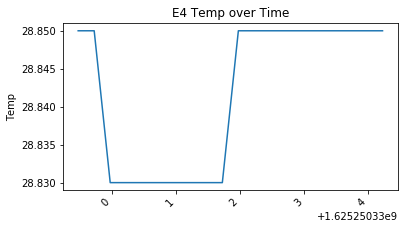

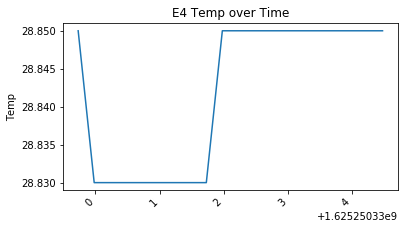

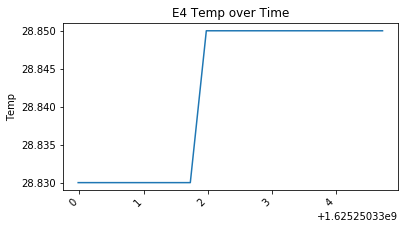

E4_Temperature 1625250334.98001 28.89



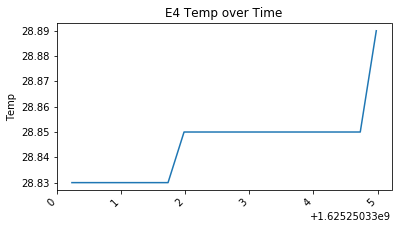

E4_Temperature 1625250335.23003 28.89
E4_Temperature 1625250335.48004 28.89
E4_Temperature 1625250335.73005 28.89
E4_Temperature 1625250335.98006 28.87
E4_Temperature 1625250336.23007 28.87
E4_Temperature 1625250336.48008 28.87
E4_Temperature 1625250336.7301 28.87



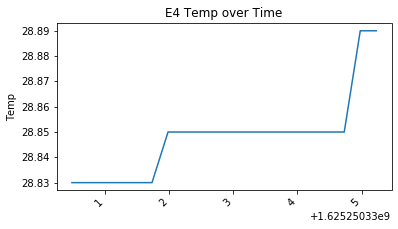

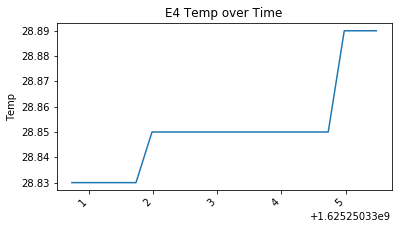

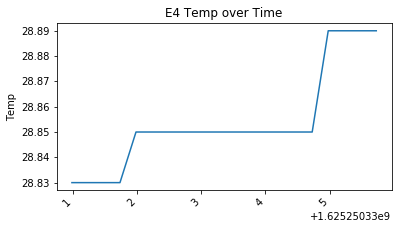

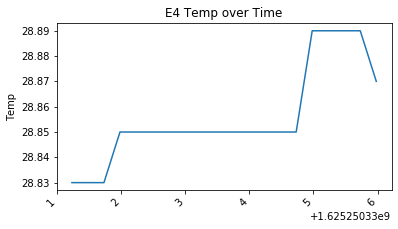

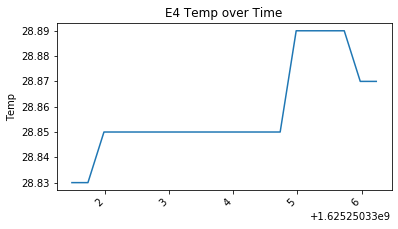

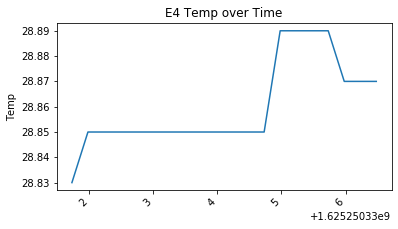

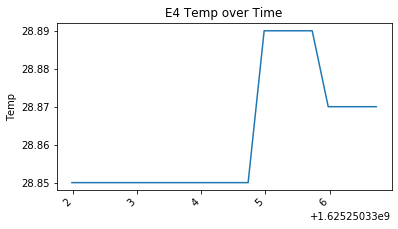

E4_Temperature 1625250336.98011 28.89



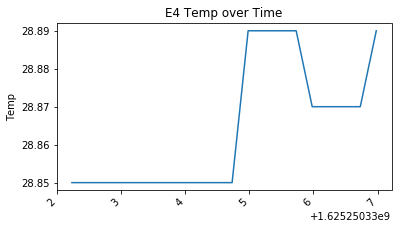

E4_Temperature 1625250337.23012 28.89
E4_Temperature 1625250337.48013 28.89
E4_Temperature 1625250337.73014 28.89
E4_Temperature 1625250337.98015 28.91
E4_Temperature 1625250338.23017 28.91
E4_Temperature 1625250338.48018 28.91
E4_Temperature 1625250338.73019 28.91



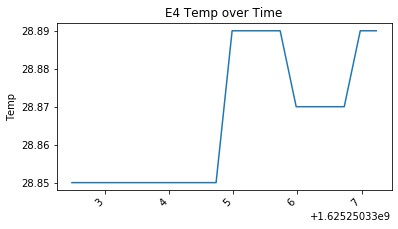

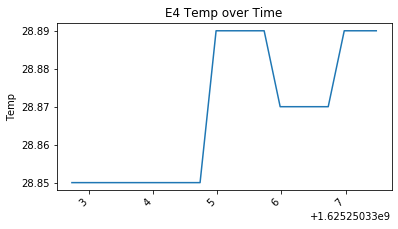

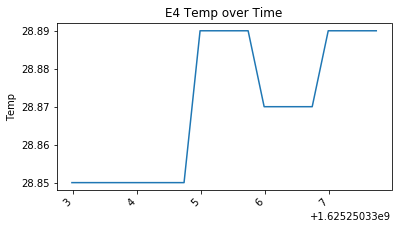

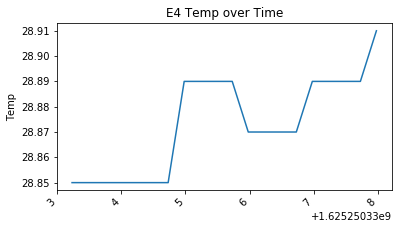

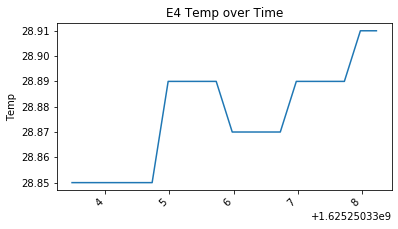

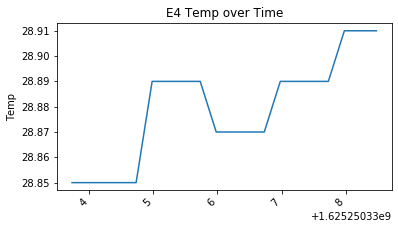

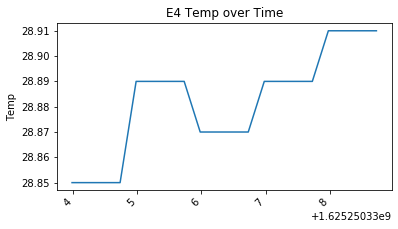

E4_Temperature 1625250338.9802 28.91
E4_Temperature 1625250339.23021 28.91



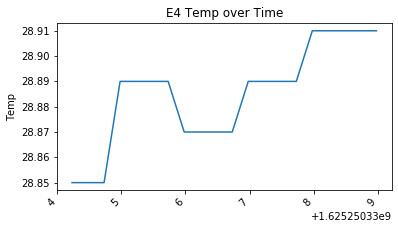

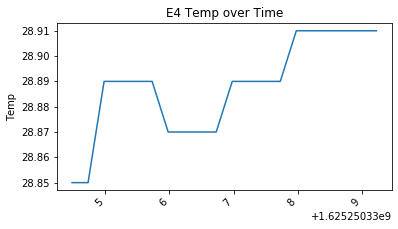

E4_Temperature 1625250339.48022 28.91
E4_Temperature 1625250339.73023 28.91
E4_Temperature 1625250339.98025 28.91
E4_Temperature 1625250340.23026 28.91
E4_Temperature 1625250340.48027 28.91
E4_Temperature 1625250340.73028 28.91



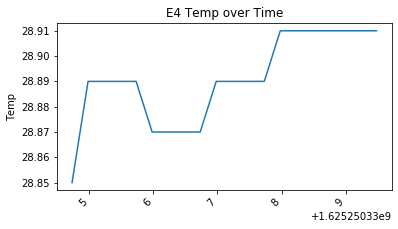

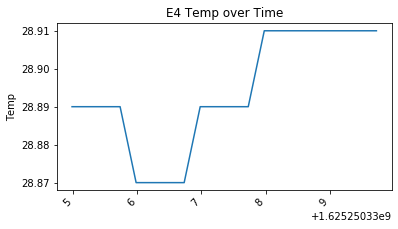

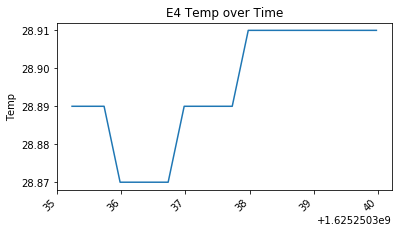

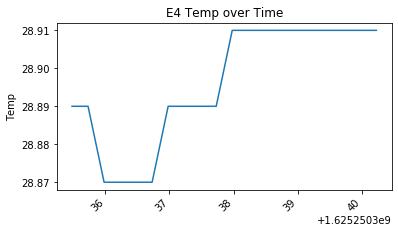

Disconnecting from device


In [22]:
import socket
import time
import pylsl
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#%matplotlib qt

# SELECT DATA TO STREAM
acc = False      # 3-axis acceleration
bvp = False      # Blood Volume Pulse
gsr = False      # Galvanic Skin Response (Electrodermal Activity)
tmp = True       # Temperature
ibi = False      # Interbeat Interval and Heartbeat
bat = False      # Device Battery
tag = False      # Tag taken from the device (by pressing the button)

serverAddress = '127.0.0.1'
serverPort = 28000
bufferSize = 4096

deviceID = 'CDCB11' # 'A03003'

def connect():
    global s
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.settimeout(3)

    print("Connecting to server")
    s.connect((serverAddress, serverPort))
    print("Connected to server\n")

    print("Devices available:")
    s.send("device_list\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Connecting to device")
    s.send(("device_connect " + deviceID + "\r\n").encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))

    print("Pausing data receiving")
    s.send("pause ON\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
connect()

time.sleep(1)

def suscribe_to_data():
    if acc:
        print("Suscribing to ACC")
        s.send(("device_subscribe " + 'acc' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bvp:
        print("Suscribing to BVP")
        s.send(("device_subscribe " + 'bvp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if gsr:
        print("Suscribing to GSR")
        s.send(("device_subscribe " + 'gsr' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tmp:
        print("Suscribing to Temp")
        s.send(("device_subscribe " + 'tmp' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if ibi:
        print("Suscribing to IBI")
        s.send(("device_subscribe " + 'ibi' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if bat:
        print("Suscribing to Batt")
        s.send(("device_subscribe " + 'bat' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))
    if tag:
        print("Suscribing to Tag")
        s.send(("device_subscribe " + 'tag' + " ON\r\n").encode())
        response = s.recv(bufferSize)
        print(response.decode("utf-8"))

    print("Resuming data receiving")
    s.send("pause OFF\r\n".encode())
    response = s.recv(bufferSize)
    print(response.decode("utf-8"))
suscribe_to_data()

time.sleep(1)

def reconnect():
    print("Reconnecting...")
    connect()
    suscribe_to_data()
    stream()

global bvp_timestamp
bvp_timestamp = []
global bvp_data
bvp_data = []
temp_timestamp = []
temp_data = []

""" global fig
fig = plt.figure()
global ax
ax = fig.add_subplot(1, 1, 1)

def animate(i, xs, ys):

    # Read temperature (Celsius) from TMP102
    #temp_c = round(tmp102.read_temp(), 2)
    # NEEDS UPDATE HERE!

    # Add x and y to lists
    #xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
    #ys.append(temp_c) 

    # Limit x and y lists to 1000 items
    xs = xs[-1000:]
    ys = ys[-1000:]

    # Draw x and y lists
    ax.clear()
    ax.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('E4 BVP over Time')
    plt.ylabel('BVP')  """


def stream():
    try:
        print("Streaming...")
        while True:
            try:
                response = s.recv(bufferSize).decode("utf-8")
                print(response)
                if "connection lost to device" in response:
                    print(response.decode("utf-8"))
                    reconnect()
                    break
                samples = response.split("\n")
                for i in range(len(samples)-1):
                    stream_type = samples[i].split()[0]
                    """ if stream_type == "E4_Acc":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = [int(samples[i].split()[2].replace(',','.')), int(samples[i].split()[3].replace(',','.')), int(samples[i].split()[4].replace(',','.'))]
                        outletACC.push_sample(data, timestamp=timestamp) """
                    if stream_type == "E4_Bvp":
                        bvp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        bvp_new_data = float(samples[i].split()[2].replace(',','.'))
                        bvp_timestamp.append(bvp_new_timestamp)
                        bvp_data.append(bvp_new_data)                        
                    """ if stream_type == "E4_Gsr":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletGSR.push_sample([data], timestamp=timestamp) """
                    if stream_type == "E4_Temperature":
                        temp_new_timestamp = float(samples[i].split()[1].replace(',','.'))
                        temp_new_data = float(samples[i].split()[2].replace(',','.'))
                        temp_timestamp.append(temp_new_timestamp)
                        temp_data.append(temp_new_data)
                    """ if stream_type == "E4_Ibi":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletIBI.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Tag":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletTag.push_sample([data], timestamp=timestamp) """
                    """ if stream_type == "E4_Battery":
                        timestamp = float(samples[i].split()[1].replace(',','.'))
                        data = float(samples[i].split()[2].replace(',','.'))
                        outletBatt.push_sample([data], timestamp=timestamp) """
                    fig = plt.figure()
                    ax = fig.add_subplot(1, 1, 1)

                    def animate(i, xs, ys):

                        # Read temperature (Celsius) from TMP102
                        #temp_c = round(tmp102.read_temp(), 2)
                        # NEEDS UPDATE HERE!

                        # Add x and y to lists
                        #xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
                        #ys.append(temp_c) 

                        # Limit x and y lists to 20 items
                        xs = xs[-20:]
                        ys = ys[-20:]

                        # Draw x and y lists
                        ax.clear()
                        ax.plot(xs, ys)

                        # Format plot
                        plt.xticks(rotation=45, ha='right')
                        plt.subplots_adjust(bottom=0.30)
                        plt.title('E4 Temp over Time')
                        plt.ylabel('Temp') 
                    # Set up plot to call animate() function periodically
                    ani = animation.FuncAnimation(fig, animate, fargs=(temp_timestamp, temp_data), interval=1000)
                    plt.show()
                #time.sleep(1)
            except socket.timeout:
                print("Socket timeout")
                reconnect()
                break
    except KeyboardInterrupt:
        print("Disconnecting from device")
        s.send("device_disconnect\r\n".encode())
        s.close()
stream()


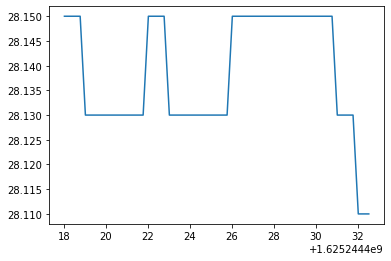

In [12]:
#%matplotlib qt
%matplotlib inline

plt.plot(temp_timestamp, temp_data)

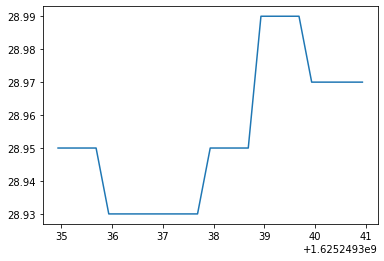

In [19]:
#%matplotlib qt
%matplotlib inline

plt.plot(temp_timestamp, temp_data)

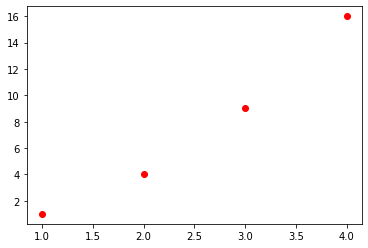

In [46]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
plt.show()


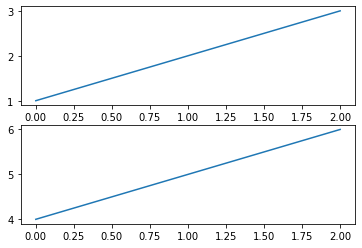

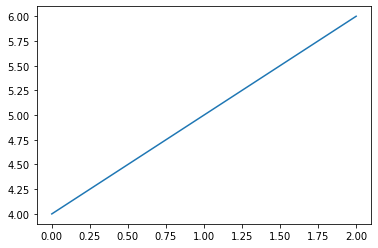

In [56]:
plt.figure(1)                # the first figure
plt.subplot(211)             # the first subplot in the first figure
plt.plot([1, 2, 3])
plt.subplot(212)             # the second subplot in the first figure
plt.plot([4, 5, 6])

plt.figure(2)                # a second figure
plt.plot([4, 5, 6])          # creates a subplot() by default



In [50]:
plt.clf()

<Figure size 432x288 with 0 Axes>

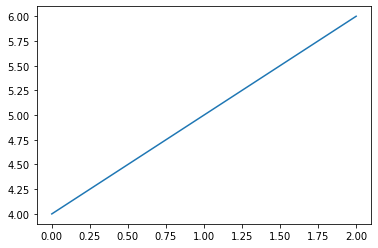

In [61]:
plt.plot([1,2,3])

plt.cla()
plt.plot([4,5,6])


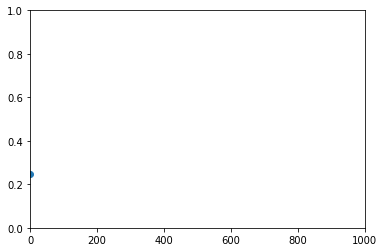

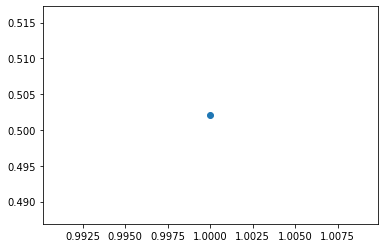

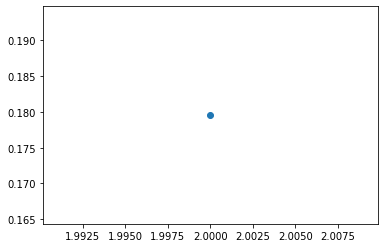

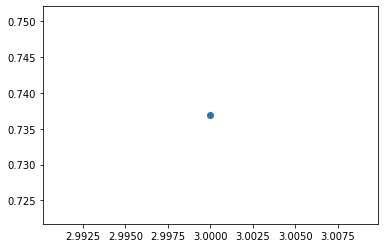

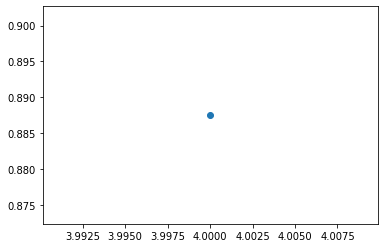

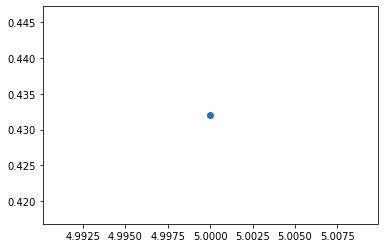

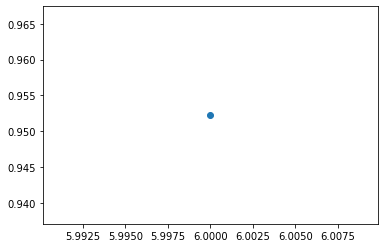

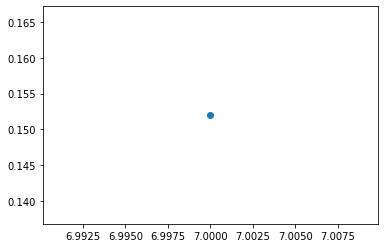

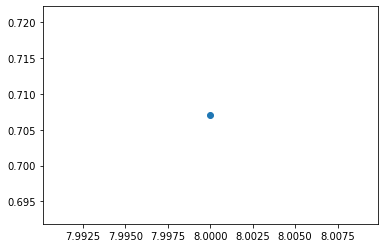

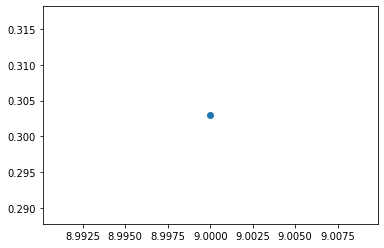

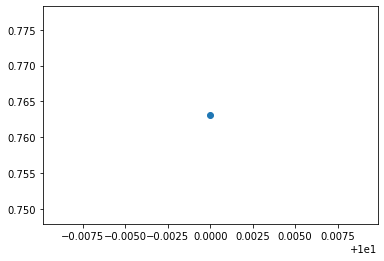

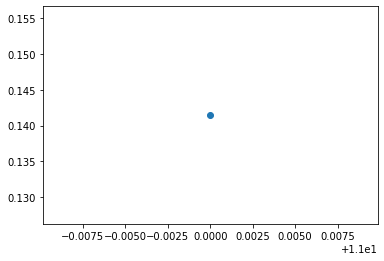

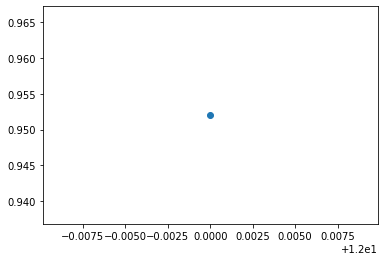

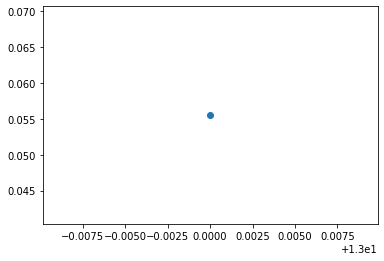

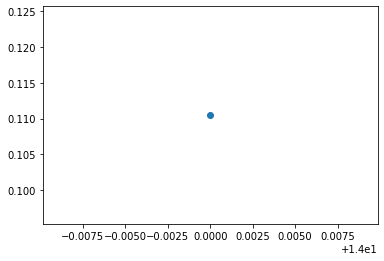

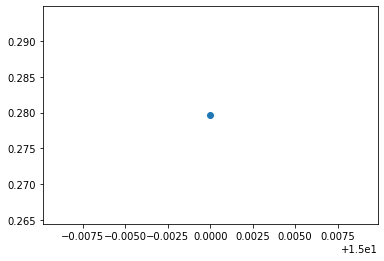

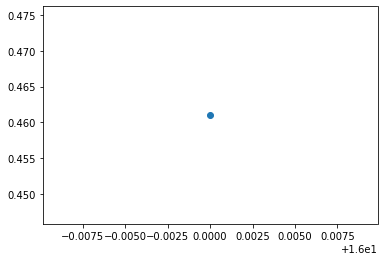

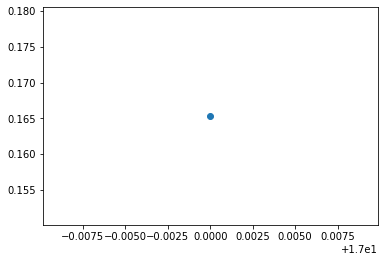

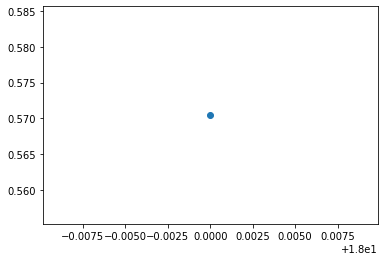

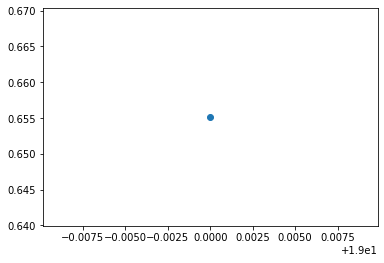

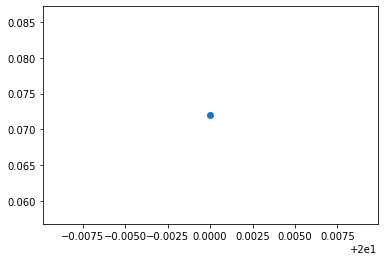

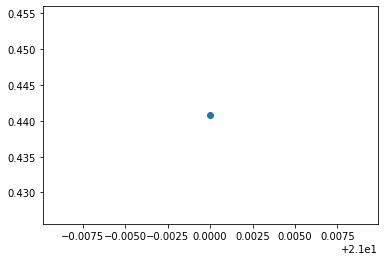

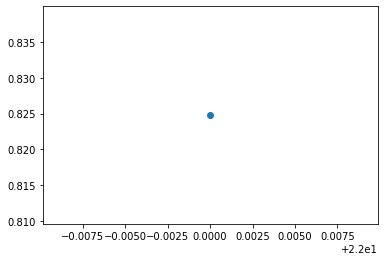

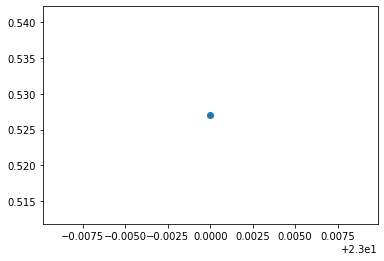

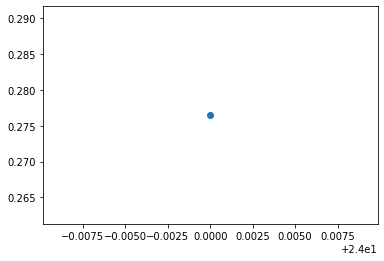

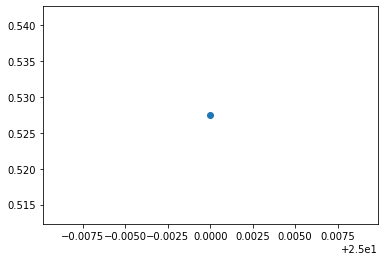

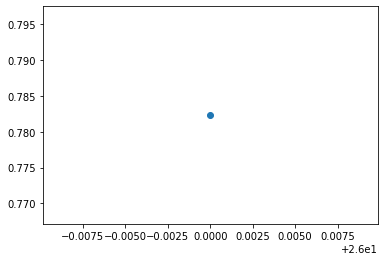

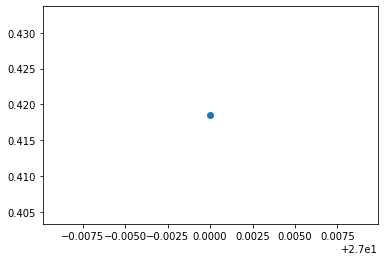

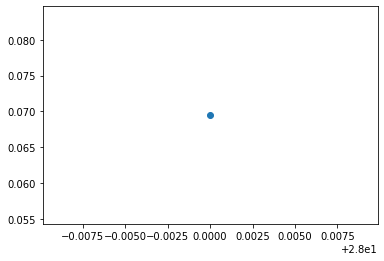

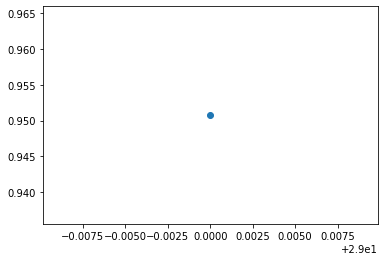

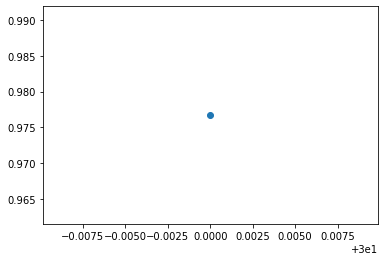

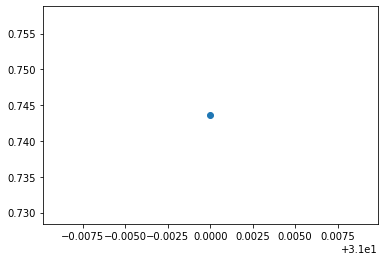

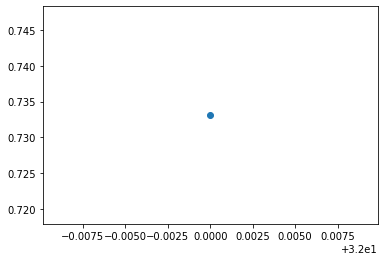

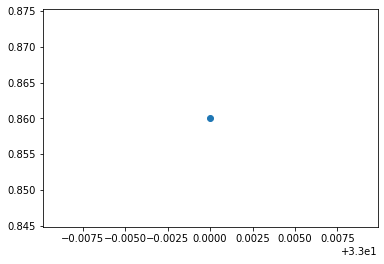

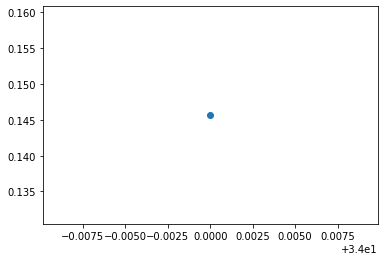

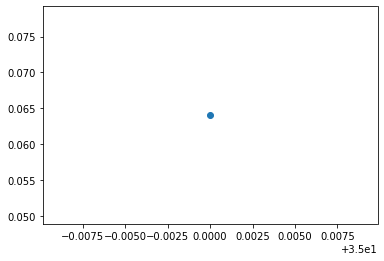

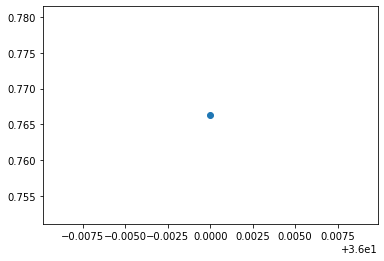

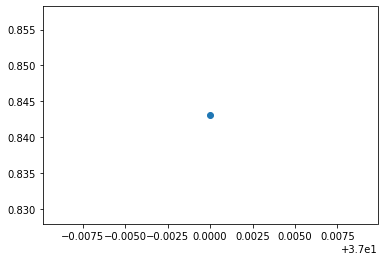

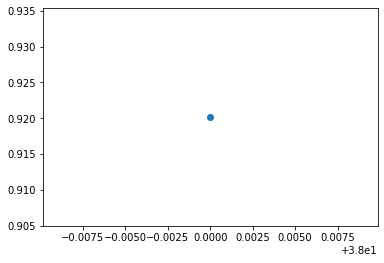

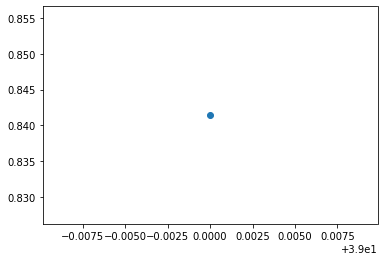

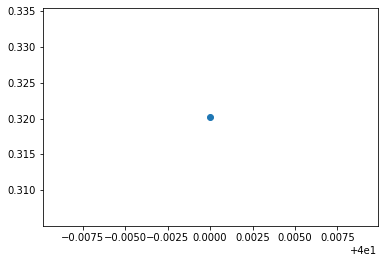

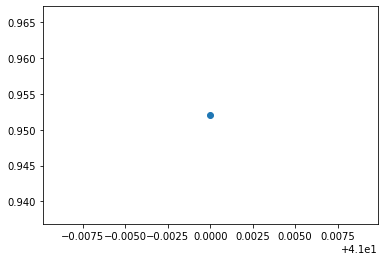

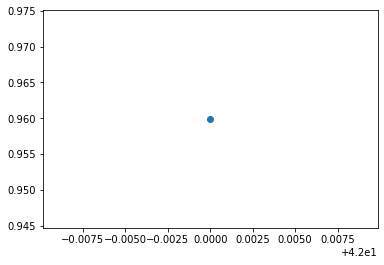

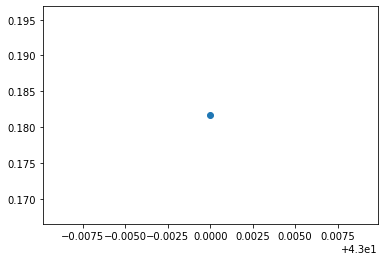

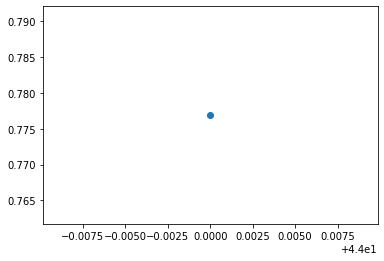

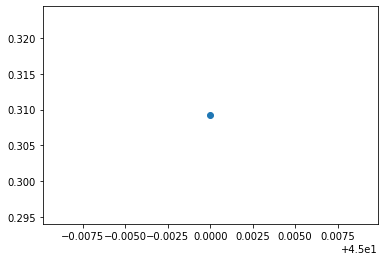

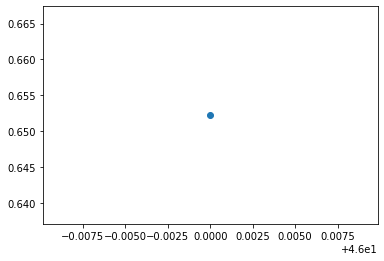

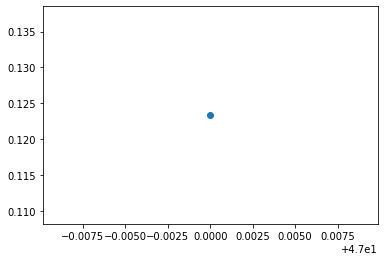

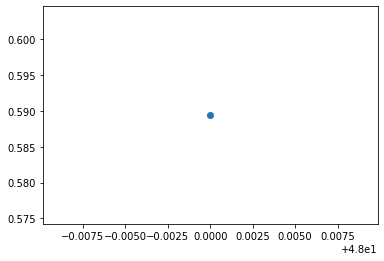

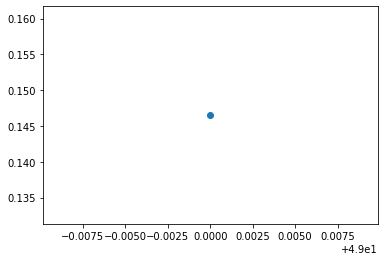

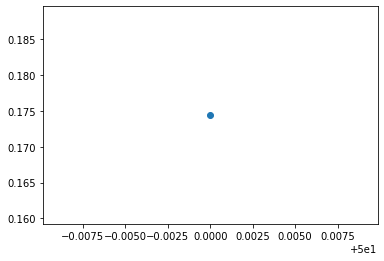

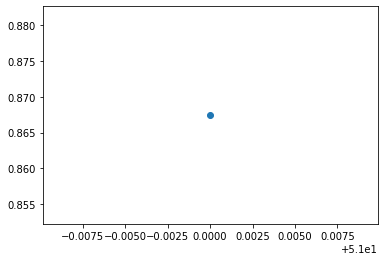

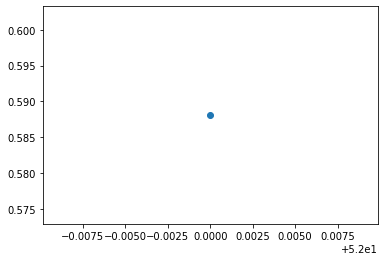

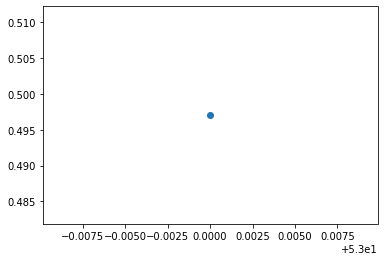

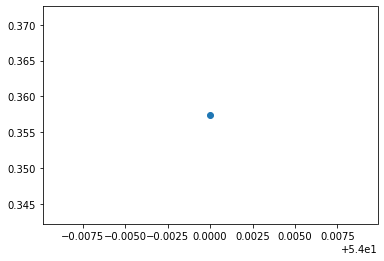

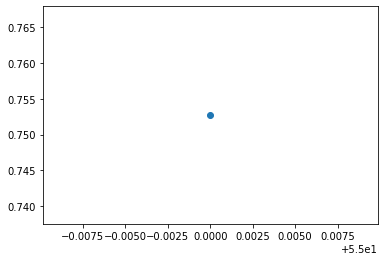

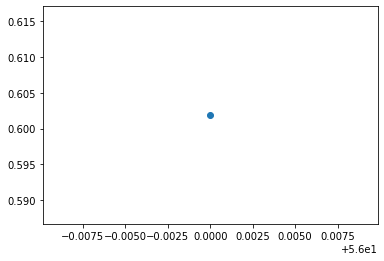

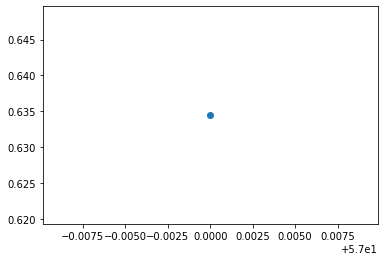

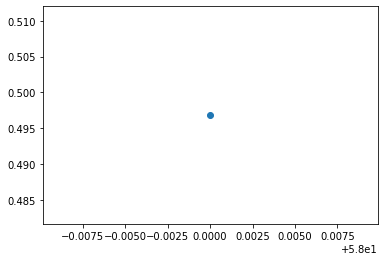

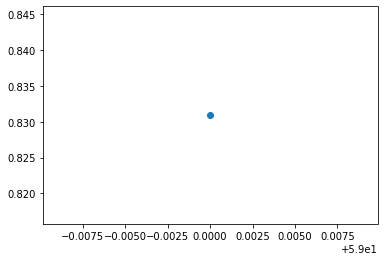

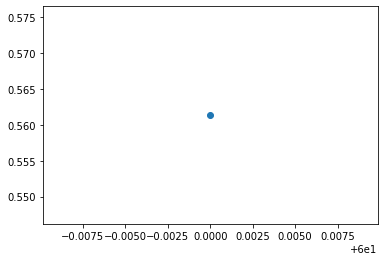

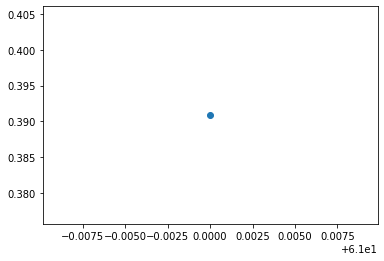

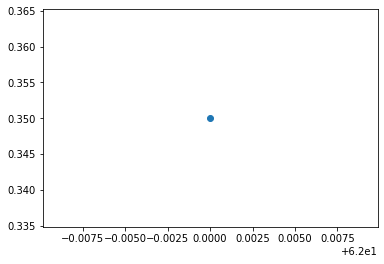

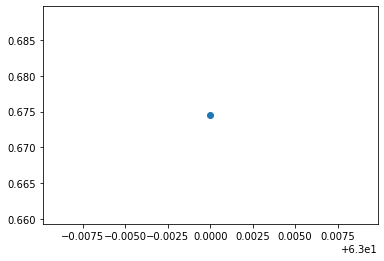

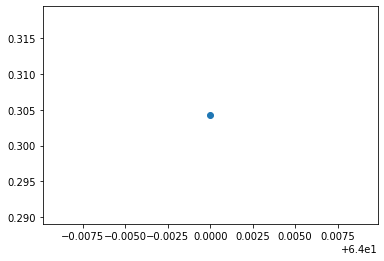

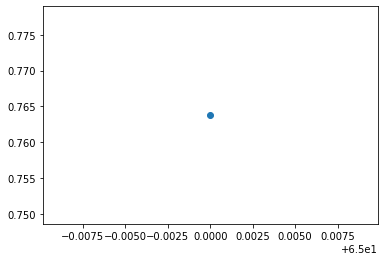

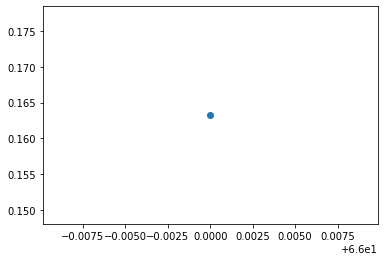

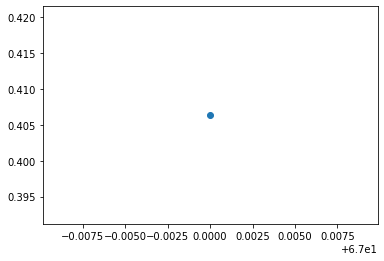

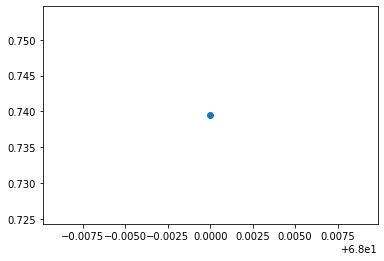

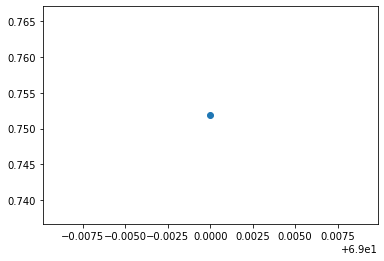

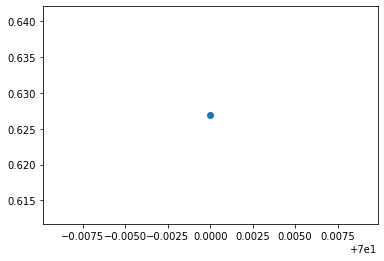

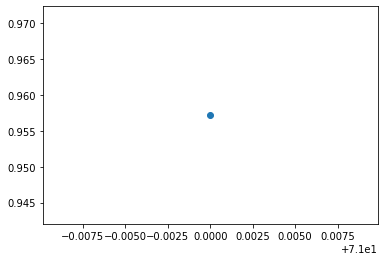

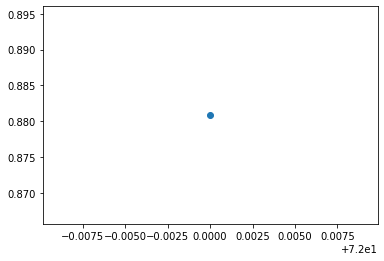

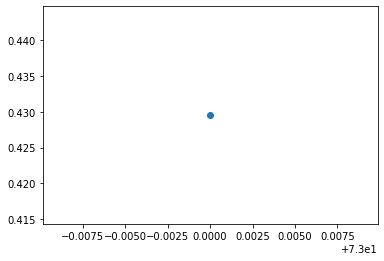

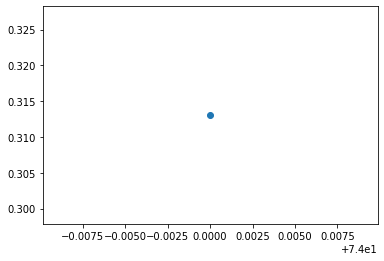

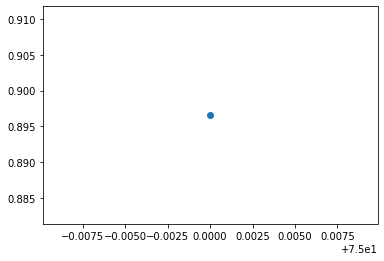

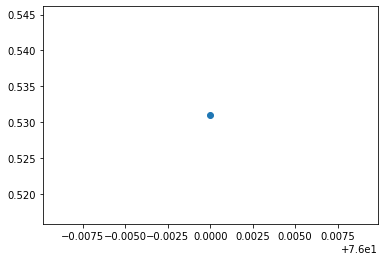

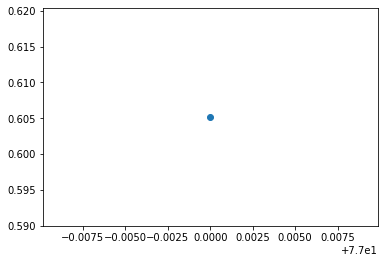

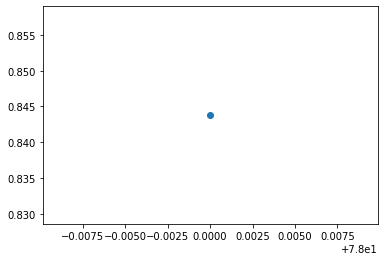

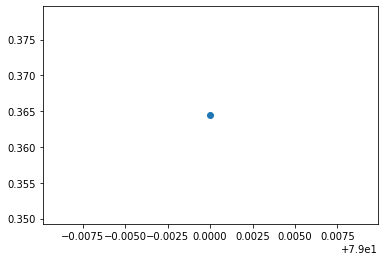

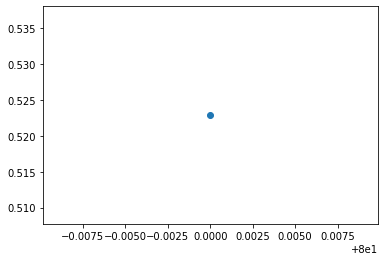

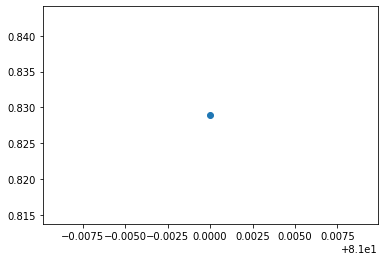

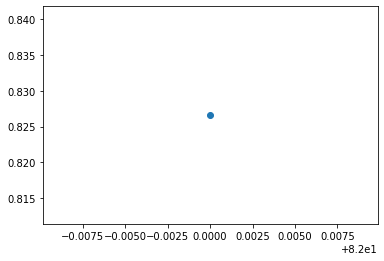

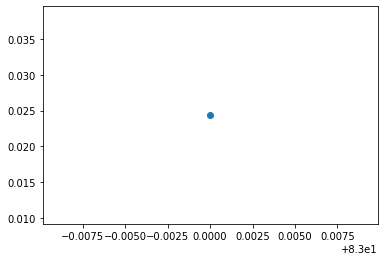

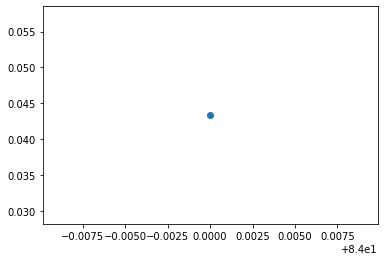

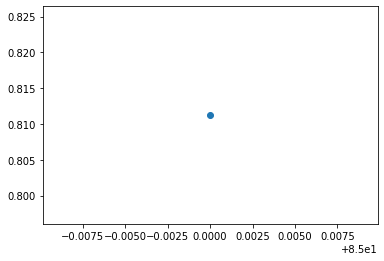

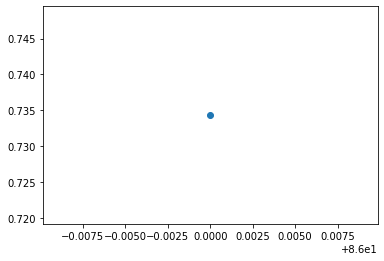

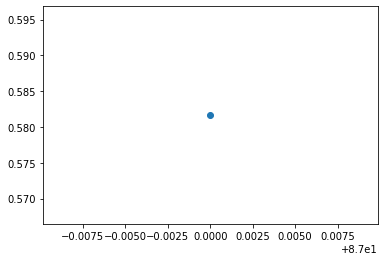

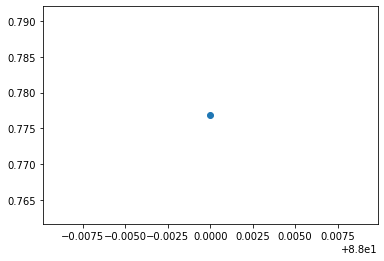

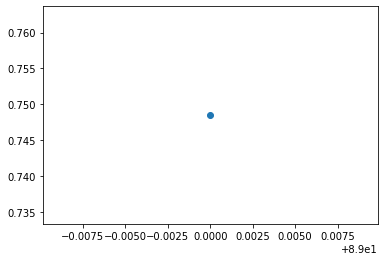

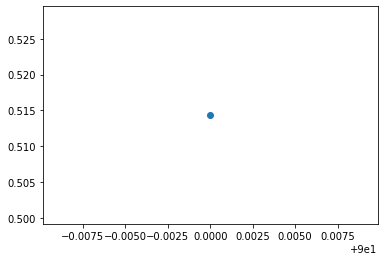

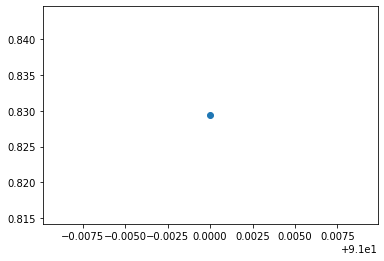

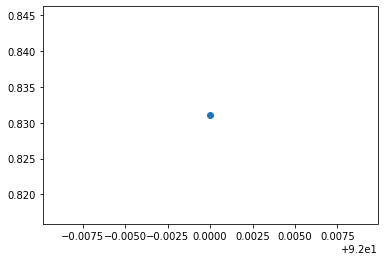

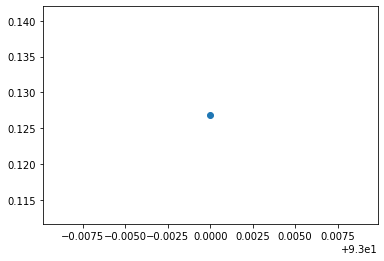

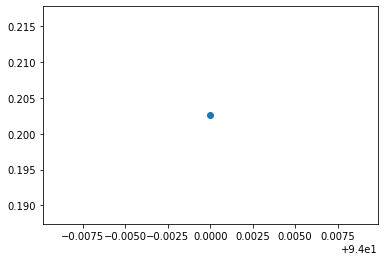

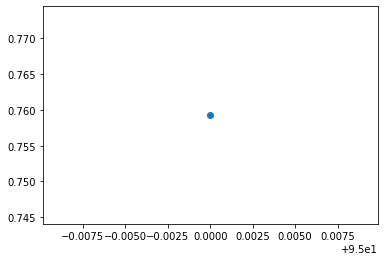

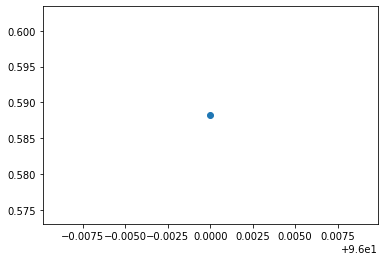

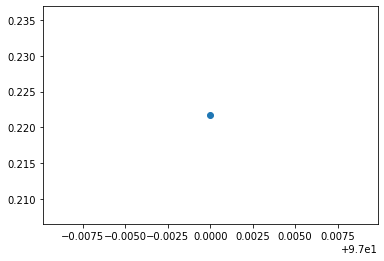

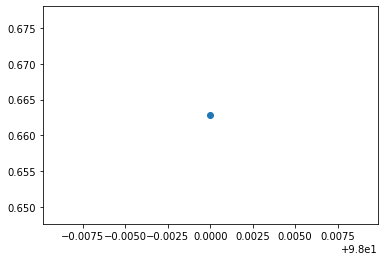

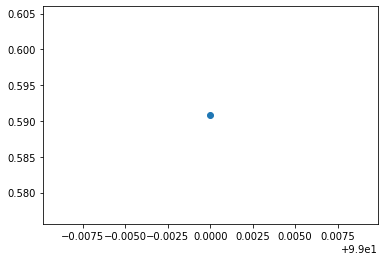

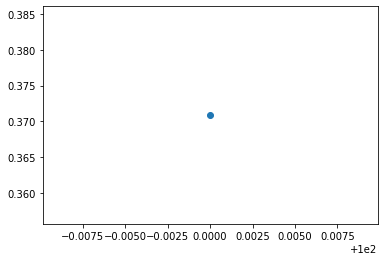

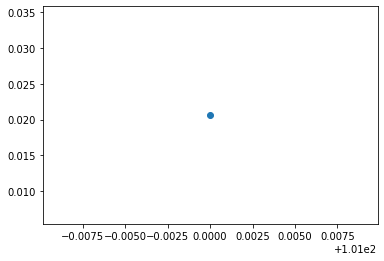

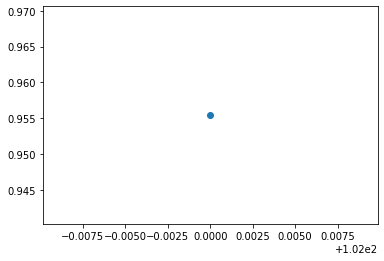

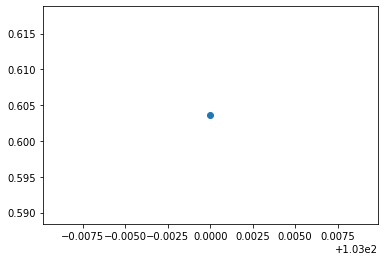

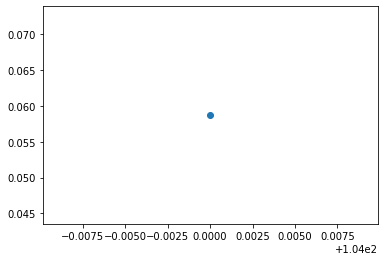

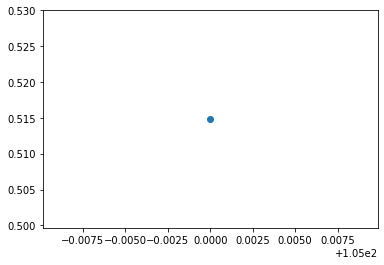

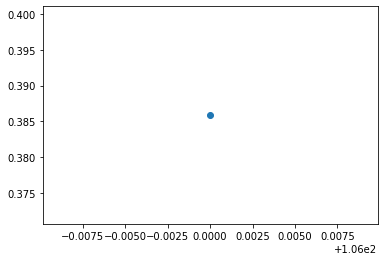

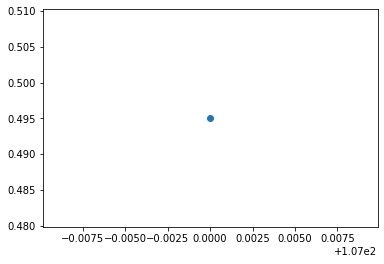

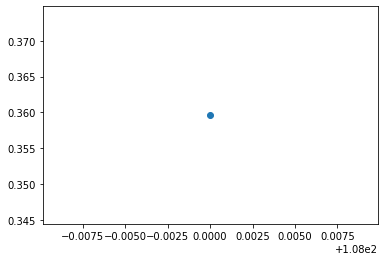

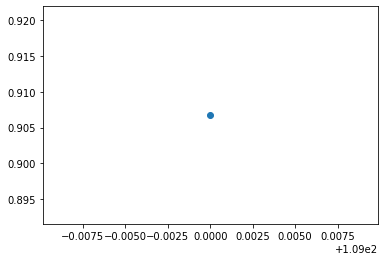

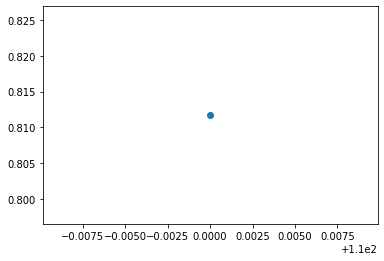

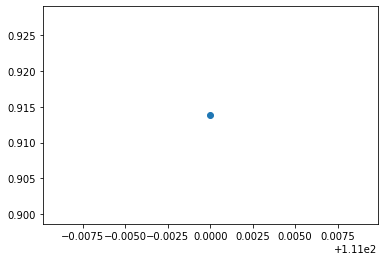

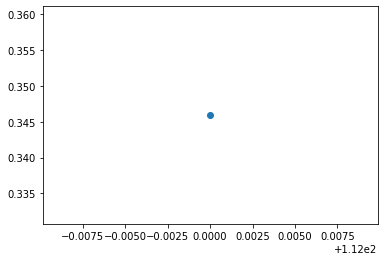

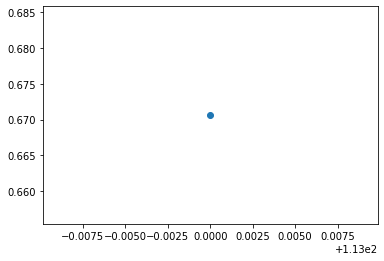

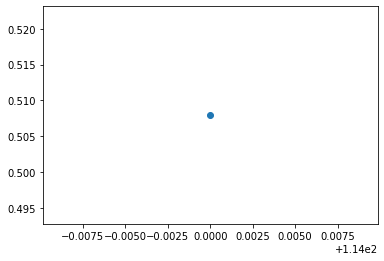

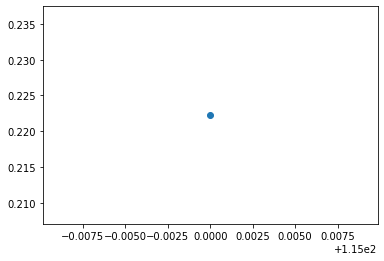

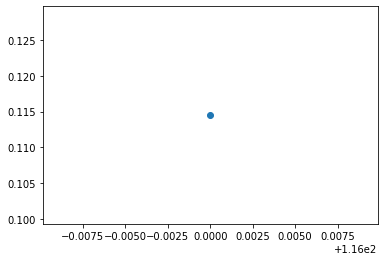

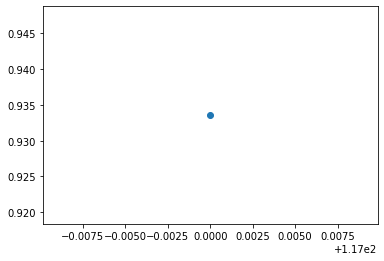

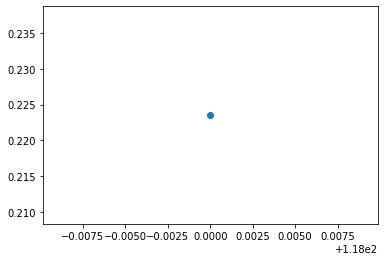

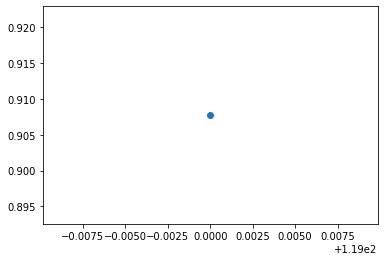

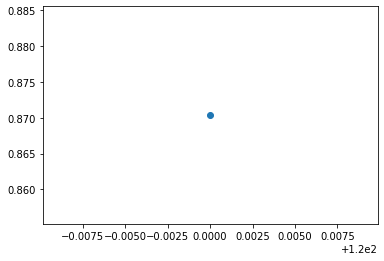

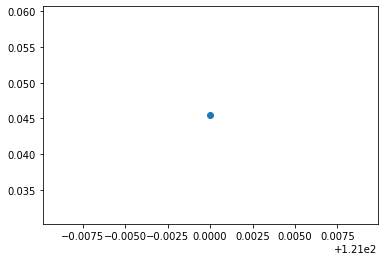

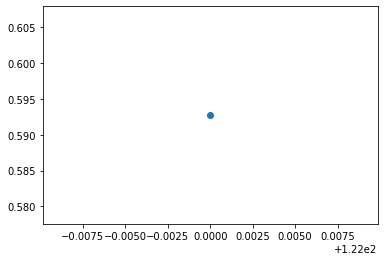

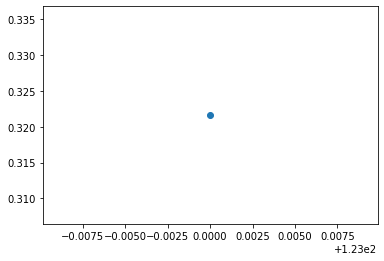

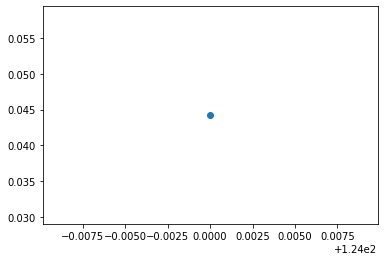

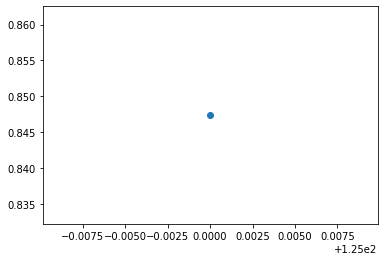

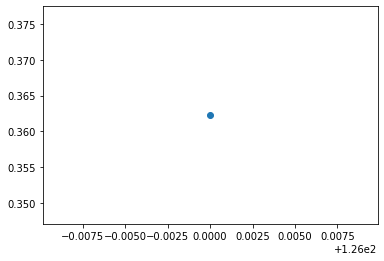

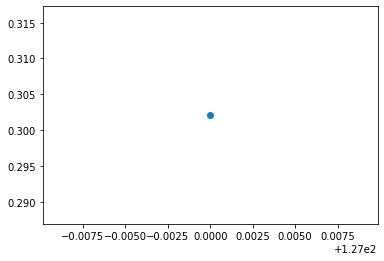

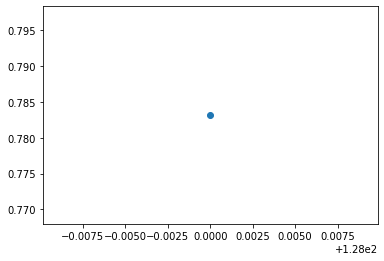

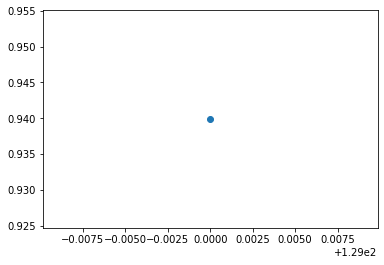

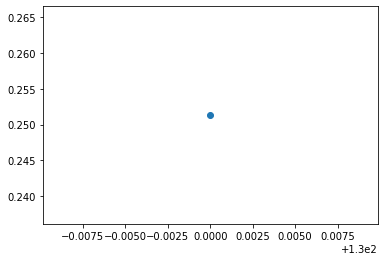

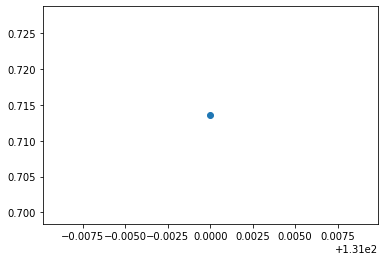

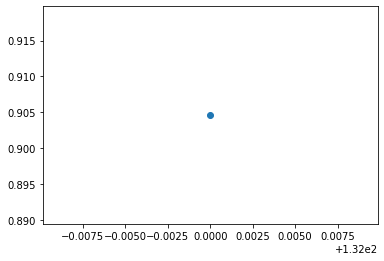

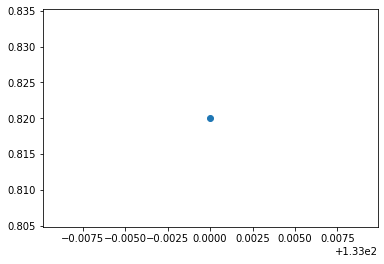

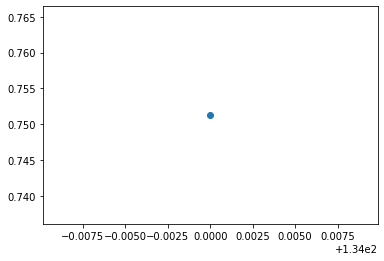

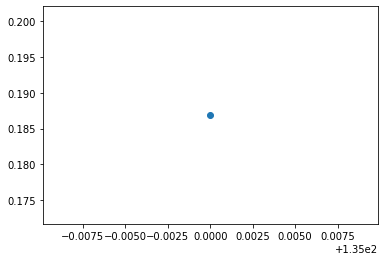

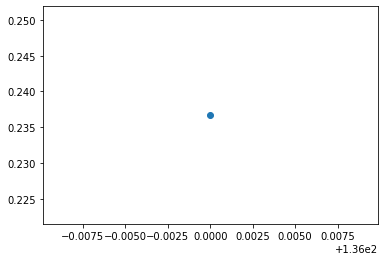

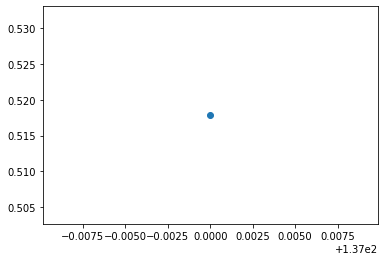

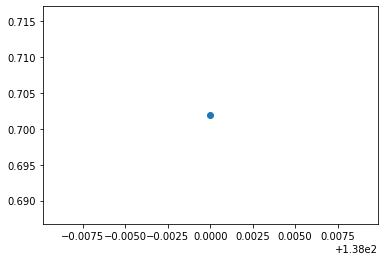

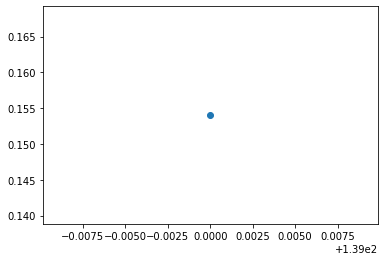

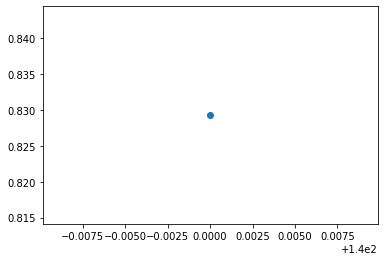

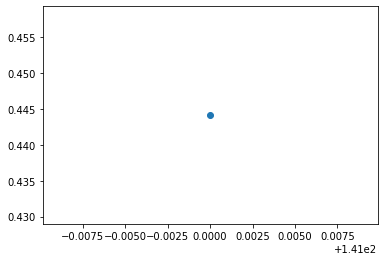

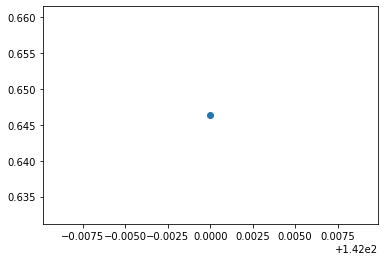

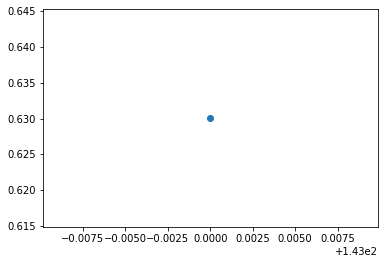

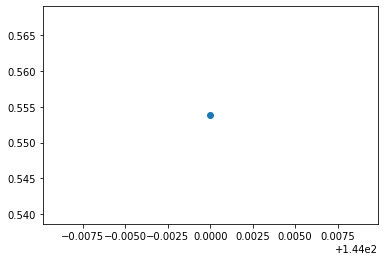

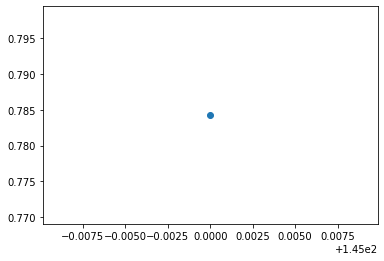

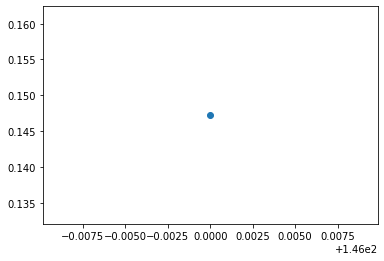

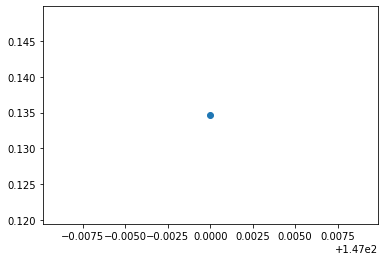

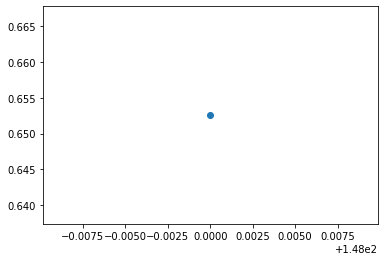

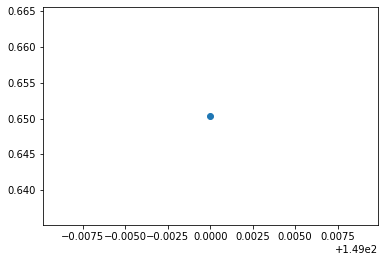

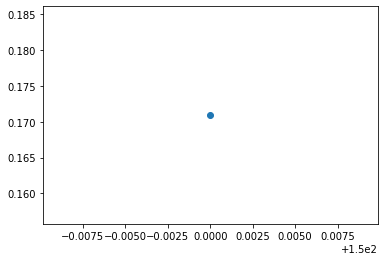

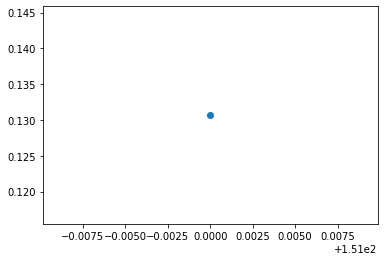

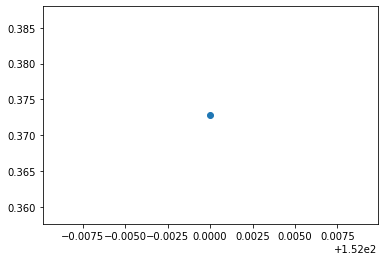

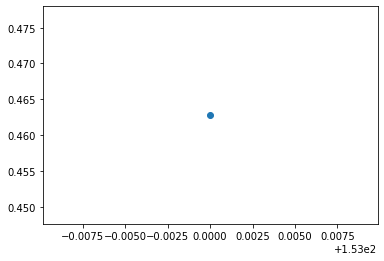

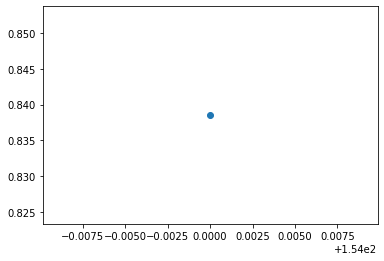

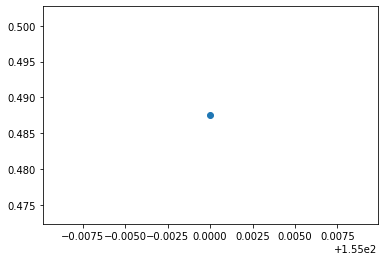

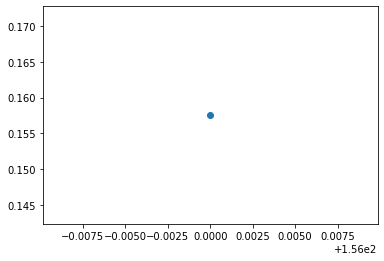

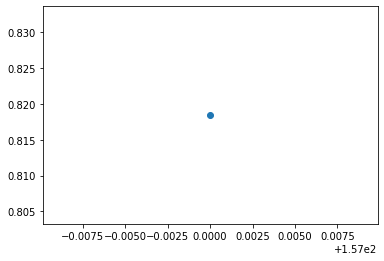

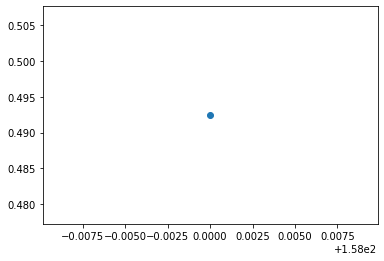

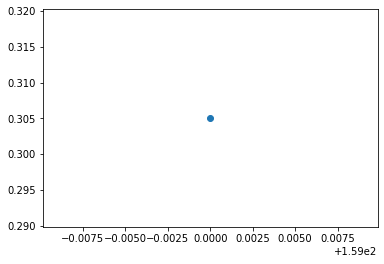

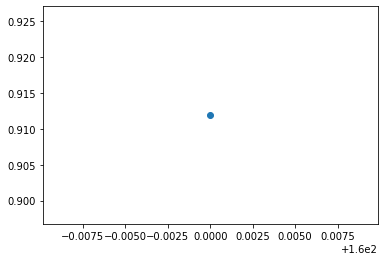

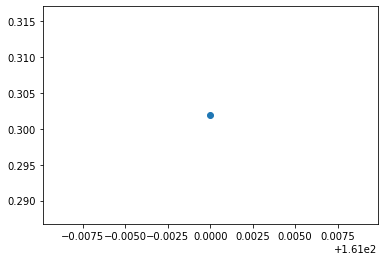

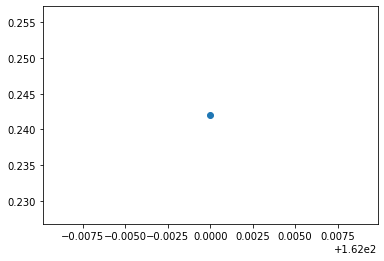

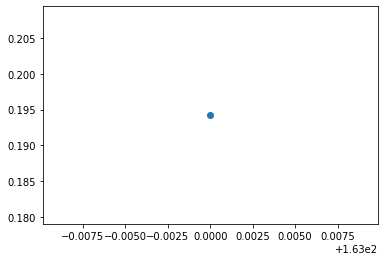

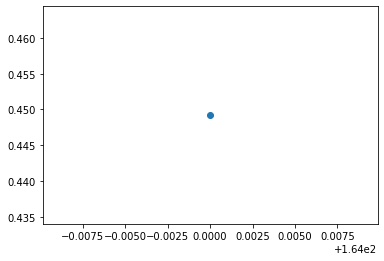

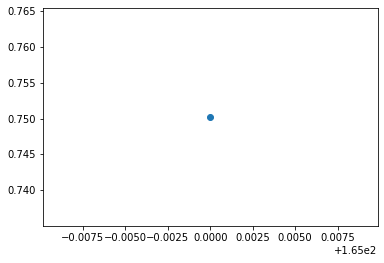

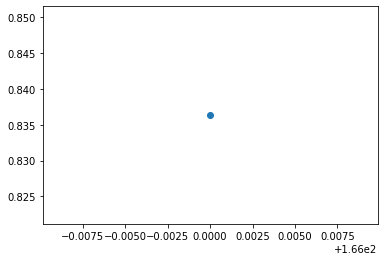

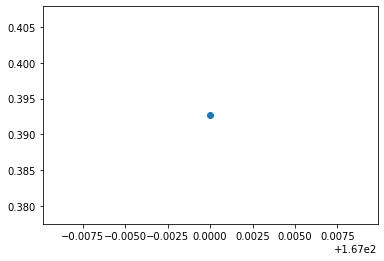

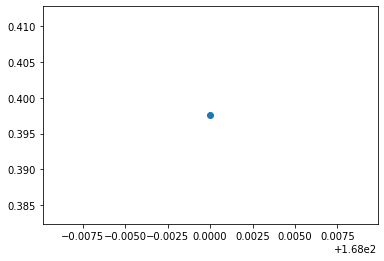

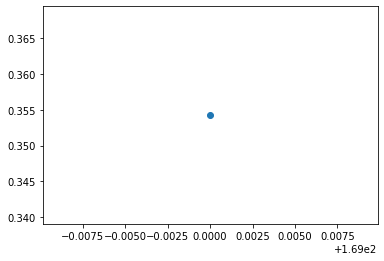

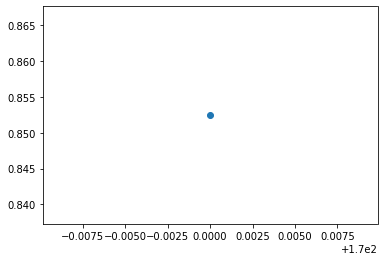

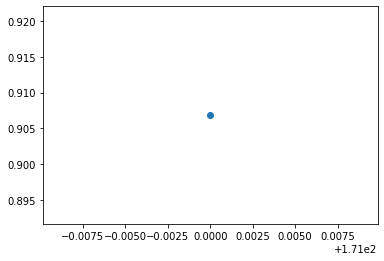

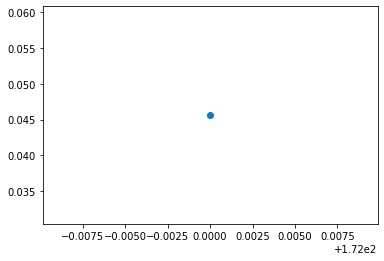

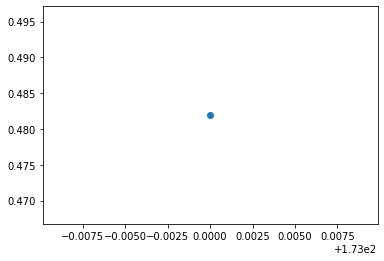

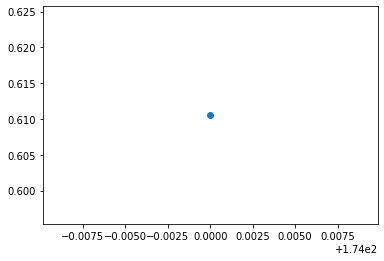

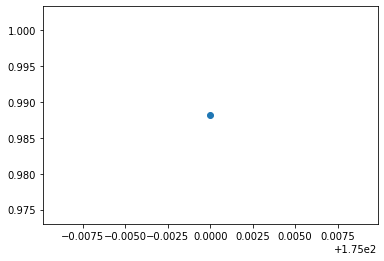

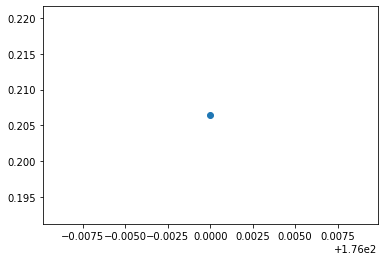

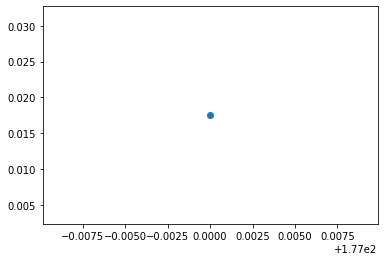

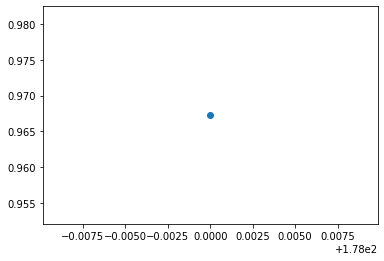

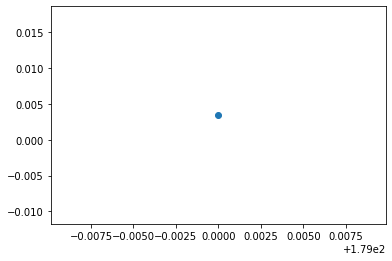

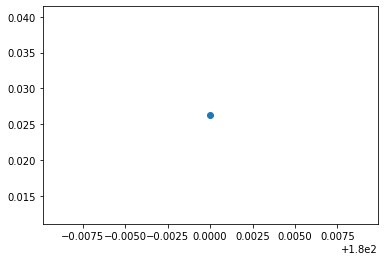

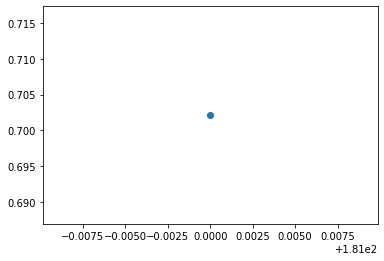

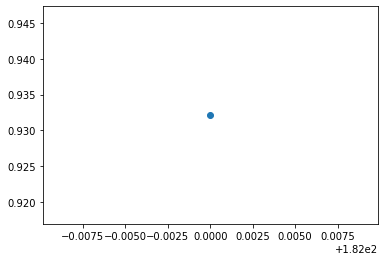

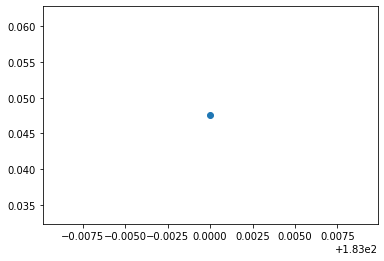

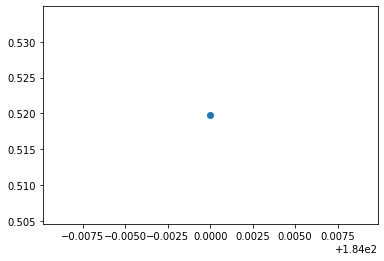

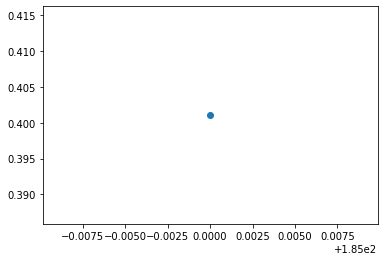

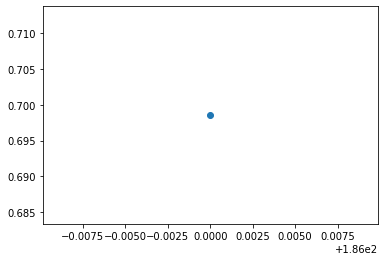

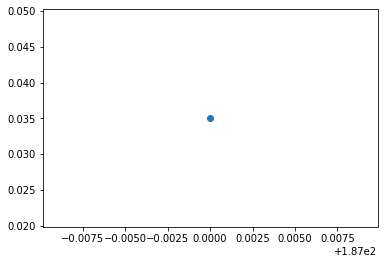

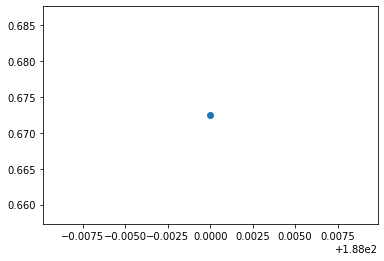

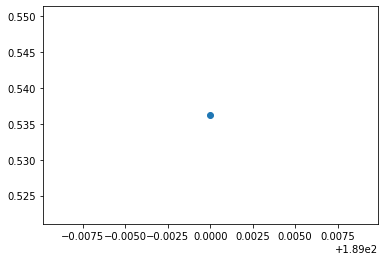

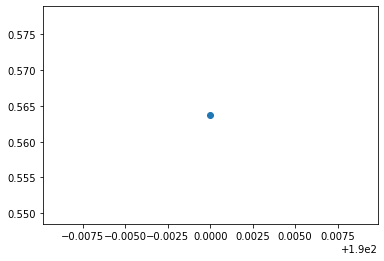

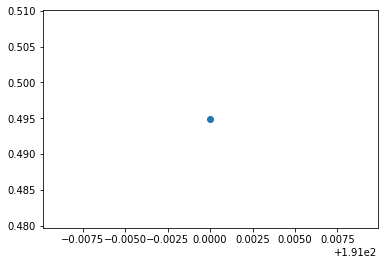

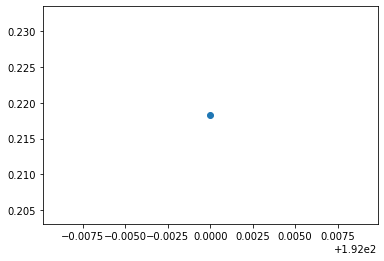

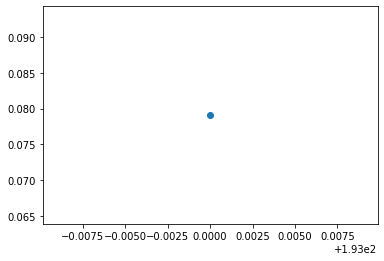

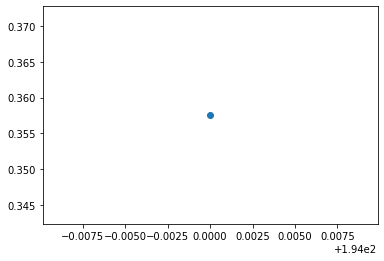

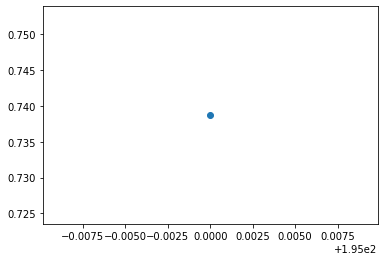

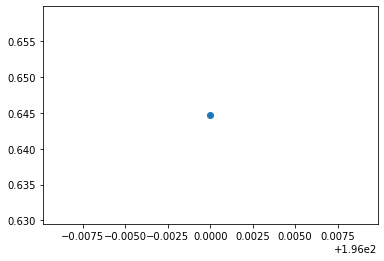

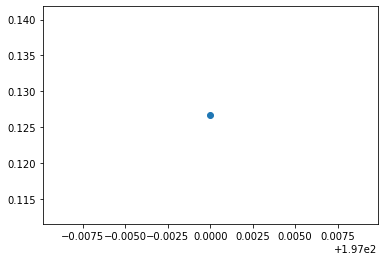

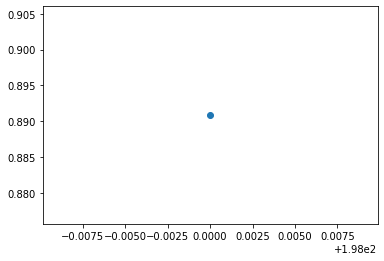

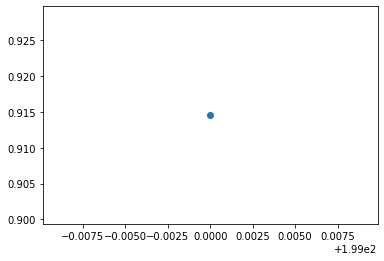

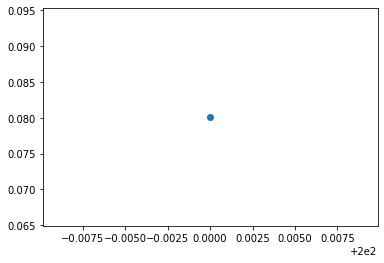

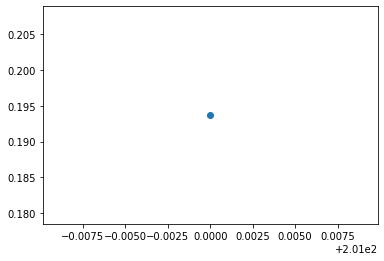

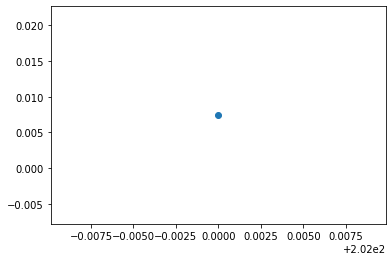

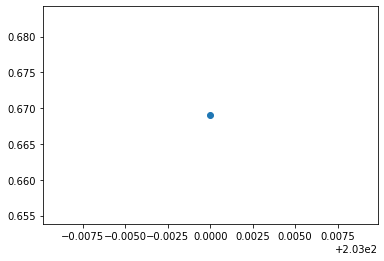

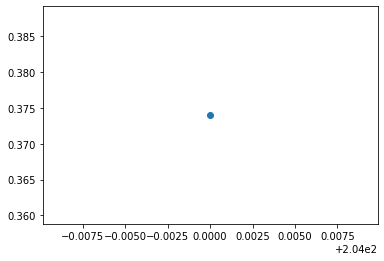

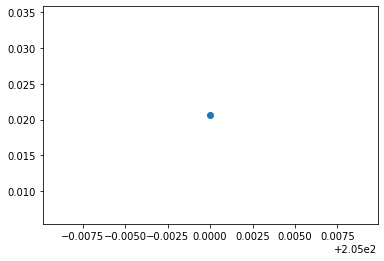

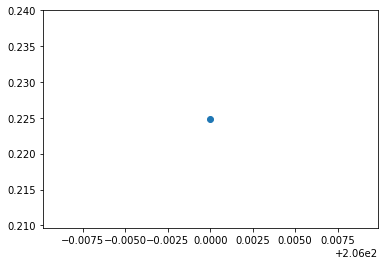

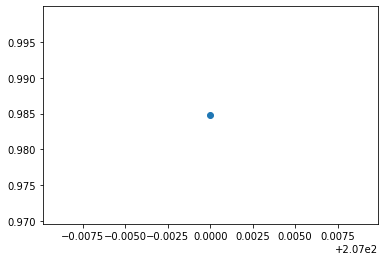

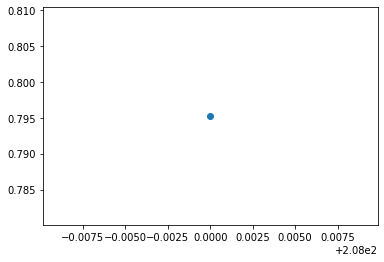

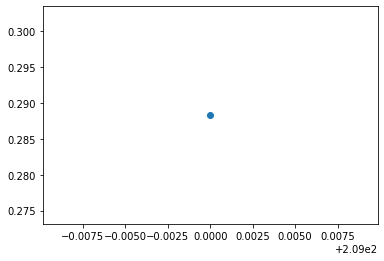

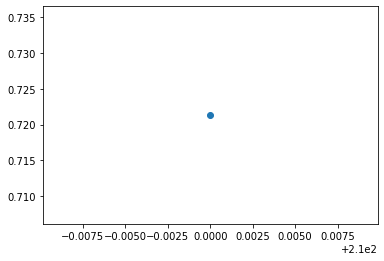

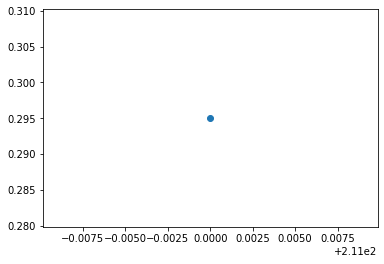

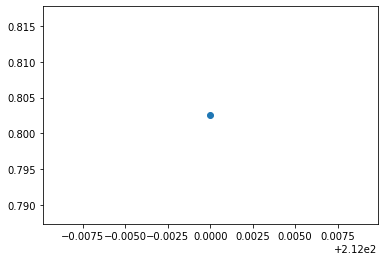

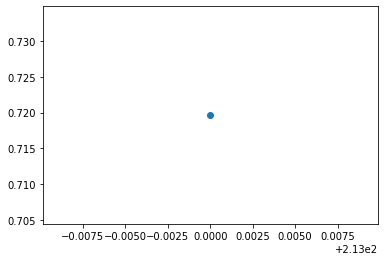

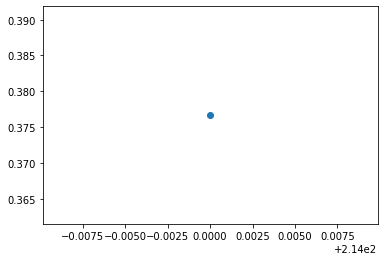

KeyboardInterrupt: 

In [63]:
import matplotlib.pyplot as plt
import numpy as np
plt.ion() ## Note this correction
fig=plt.figure()
plt.axis([0,1000,0,1])

i=0
x=list()
y=list()

while i <1000:
    temp_y=np.random.random();
    x.append(i);
    y.append(temp_y);
    plt.scatter(i,temp_y);
    i+=1;
    plt.show()
    plt.pause(0.0001) #Note this correction

In [24]:
from datetime import datetime

test = datetime.fromtimestamp(temp_timestamp[0])
print(test)

2021-07-02 11:25:18.979270


In [39]:
test2 = []
for i in range(len(temp_timestamp)):
    test2.append(datetime.fromtimestamp(temp_timestamp[i]))



#test2 = datetime.fromtimestamp(temp_timestamp)
print(test2)

[datetime.datetime(2021, 7, 2, 11, 25, 18, 979270), datetime.datetime(2021, 7, 2, 11, 25, 19, 229290), datetime.datetime(2021, 7, 2, 11, 25, 19, 479300), datetime.datetime(2021, 7, 2, 11, 25, 19, 729310), datetime.datetime(2021, 7, 2, 11, 25, 19, 979320), datetime.datetime(2021, 7, 2, 11, 25, 20, 229330), datetime.datetime(2021, 7, 2, 11, 25, 20, 479340), datetime.datetime(2021, 7, 2, 11, 25, 20, 729350), datetime.datetime(2021, 7, 2, 11, 25, 20, 979370), datetime.datetime(2021, 7, 2, 11, 25, 21, 229380), datetime.datetime(2021, 7, 2, 11, 25, 21, 479390), datetime.datetime(2021, 7, 2, 11, 25, 21, 729400), datetime.datetime(2021, 7, 2, 11, 25, 21, 979410), datetime.datetime(2021, 7, 2, 11, 25, 22, 229420), datetime.datetime(2021, 7, 2, 11, 25, 22, 479440), datetime.datetime(2021, 7, 2, 11, 25, 22, 729450), datetime.datetime(2021, 7, 2, 11, 25, 22, 979460), datetime.datetime(2021, 7, 2, 11, 25, 23, 229470), datetime.datetime(2021, 7, 2, 11, 25, 23, 479480), datetime.datetime(2021, 7, 2, 

In [41]:
print(test2[8])

2021-07-02 11:25:20.979370
